In [0]:
# linear Algbera library

import numpy as np
import pandas as pd 

# keras library 
import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,Concatenate
from keras.backend import random_normal,ones_like,zeros_like,mean
from keras.backend import get_session
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from PIL import Image

import os
import time
from glob import glob
import datetime

# Visualization library
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# Hyperparameters
IMG_SIZE = 64
NOISE_SIZE = 100
LR_D = 0.00004
LR_G = 0.0004
BATCH_SIZE = 64
EPOCHS = 300 # For better results increase this value 
BETA1 = 0.5
WEIGHT_INIT_STDDEV = 0.02
EPSILON = 0.00005
SAMPLES_TO_SHOW = 5
img_rows = 64
img_cols = 64
CHANNELS = 3
img_shape = (img_rows, img_cols, CHANNELS)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
%cd "/content/drive/My Drive/Assigment_4"

/content/drive/My Drive/Assigment_4


In [9]:
%ls

cropped/  simpsons_dataset.txt


In [0]:
def GeneratorFunction(noise_shape=(NOISE_SIZE,)):
    
    input_layer = Input(noise_shape)
    generator = Dense(1024*8*8, activation='relu')(input_layer)
    generator = Reshape((8, 8, 1024)) (generator)
    generator = LeakyReLU(alpha=0.2) (generator)
                        
    generator = keras.layers.Conv2DTranspose(filters=512, kernel_size=[5,5], padding="same",
                                             strides=[2,2], kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(generator)
    generator = BatchNormalization(momentum=0.8,epsilon = EPSILON) (generator)
    generator = keras.layers.LeakyReLU(alpha=0.2) (generator)
                        
    generator = keras.layers.Conv2DTranspose(filters=256, kernel_size=[5,5], padding="same", strides=[2,2],
                                               kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(generator)
    generator = BatchNormalization(momentum=0.8,epsilon = EPSILON,name="batch_trans_conv2") (generator)
    generator = keras.layers.LeakyReLU(alpha=0.2) (generator)
                        
    generator = keras.layers.Conv2DTranspose(filters=128, kernel_size=[5,5], padding="same", strides=[2,2],
                                               kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV)) (generator)
    generator = BatchNormalization(momentum=0.8,epsilon = EPSILON,name="batch_trans_conv3") (generator)
    generator = keras.layers.LeakyReLU(alpha=0.2)(generator)
    
    generator = keras.layers.Conv2DTranspose(filters=64, kernel_size=[5,5], padding="same", strides=[1,1],
                                               kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV)) (generator)
    generator = BatchNormalization(momentum=0.8,epsilon = EPSILON,name="batch_trans_conv4") (generator)
    generator = keras.layers.LeakyReLU(alpha=0.2) (generator)
    
    generator = keras.layers.Conv2DTranspose(filters=3, kernel_size=[5,5], padding="same", strides=[1,1],
                                               kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV)) (generator)
    out = Activation("tanh")(generator)
    
    model = Model(inputs=[input_layer], outputs=out)
    model.summary()
  
    return model

In [18]:
print("Check Generator Model layers ")
model_generator = GeneratorFunction(noise_shape=(NOISE_SIZE,))


Check Generator Model layers 
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 1024)        0         
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 16, 16, 512)       13107712  
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 16, 512)       2048      
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   

In [0]:
IMG_SIZE = 64
CHANNELS = 3

In [0]:
def discriminatorFunction(img_shape=(IMG_SIZE, IMG_SIZE, CHANNELS)):
    
    input_layer = Input(img_shape)
    discriminator = Conv2D(filters = 64, kernel_size=[5,5],strides=[2,2],kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV), 
                             padding="SAME",input_shape = img_shape)(input_layer)
    
    discriminator = BatchNormalization(momentum=0.8,epsilon = EPSILON)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(filters=128, kernel_size=[5,5], strides=[2,2], padding="same",
                              kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(discriminator)

    discriminator = BatchNormalization(momentum=0.8,epsilon = EPSILON)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(filters=256, kernel_size=[5,5], strides=[2,2], padding="same",
                             kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(discriminator)

    discriminator = BatchNormalization(momentum=0.8,epsilon = EPSILON)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(filters=512, kernel_size=[5,5], strides=[1,1], padding="same",
                             kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(discriminator)

    discriminator = BatchNormalization(momentum=0.8,epsilon = EPSILON)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(filters=1024, kernel_size=[5,5], strides=[2,2], padding="same",
                             kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(discriminator)
    
    discriminator = BatchNormalization(momentum=0.8,epsilon = EPSILON)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Flatten()(discriminator)

    out = Dense(1, activation='sigmoid')(discriminator)

    model = Model(inputs=[input_layer], outputs=out)
    model.summary()
    
    return model

In [21]:
LR_D = 0.00004
LR_G = 0.0004
model_discriminator = discriminatorFunction(img_shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
model_discriminator.compile(loss='binary_crossentropy',
                                    optimizer=Adam(lr=LR_D, beta_1=BETA1),
                                    metrics=['accuracy'])

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_14 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 16, 16, 128)       0   

In [22]:
#build the Gan Model
z = Input(shape=(NOISE_SIZE,))
img = model_generator(z)
model_discriminator.trainable = False #discriminator is not trainable for GANs
real = model_discriminator(img)
gan = Model(z, real)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=LR_G, beta_1=BETA1))
print("Model created based on Discriminator and Generator")
gan.summary()

Model created based on Discriminator and Generator
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_4 (Model)              (None, 64, 64, 3)         24036739  
_________________________________________________________________
model_5 (Model)              (None, 1)                 17439105  
Total params: 41,475,844
Trainable params: 24,034,819
Non-trainable params: 17,441,025
_________________________________________________________________


In [0]:
def show_samples(sample_images, name, epoch):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (IMG_SIZE, IMG_SIZE))
    figure.set_size_inches(15,15)
    for index, axis in enumerate(axes):
        image_array = sample_images[index]
        axis.imshow(image_array)
    plt.tight_layout()
    plt.show()
    plt.close()

In [0]:
def summarize_epoch(d_losses, g_losses):
    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    plt.show()
    plt.close()


In [25]:
lineList = [line.rstrip('\n') for line in open('simpsons_dataset.txt')]
lineList

['1. Load dataset: https://www.kaggle.com/kostastokis/simpsons-faces',
 '2. Exclude following images:',
 '',
 '["9746","9731","9717","9684","9637","9641","9642","9584","9541","9535",',
 '"9250","9251","9252","9043","8593","8584","8052","8051","8008","7957",',
 '"7958""7761","7762","9510","9307","4848","4791","4785","4465","2709",',
 '"7724","7715","7309","7064","7011","6961","6962","6963","6960","6949",',
 '"6662","6496","6409","6411","6406","6407","6170","6171","6172","5617",',
 '"4363","4232","4086","4047","3894","3889","3493","3393","3362","2780",',
 '"2710","2707","2708","2711","2712","2309","2056","1943","1760","1743",',
 '"1702","1281","1272","772","736","737","691","684","314","242","191"]']

In [0]:
# Paths
INPUT_DATA_DIR = "/content/drive/My Drive/Assigment_4/cropped/" # Path to the folder with input images. For more info check simspons_dataset.txt
OUTPUT_DIR = "../outputs"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

Images shape: (9877, 64, 64, 3)


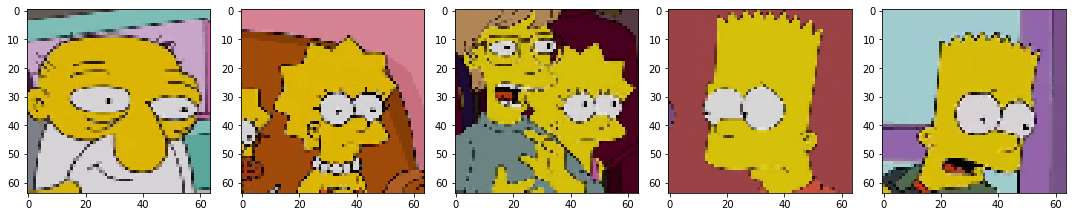

In [27]:
import cv2
import re
import random
images =[]

exclude_img = ["9746","9731","9717","9684","9637","9641","9642","9584","9541","9535",
"9250","9251","9252","9043","8593","8584","8052","8051","8008","7957",
"7958""7761","7762","9510","9307","4848","4791","4785","4465","2709",
"7724","7715","7309","7064","7011","6961","6962","6963","6960","6949",
"6662","6496","6409","6411","6406","6407","6170","6171","6172","5617",
"4363","4232","4086","4047","3894","3889","3493","3393","3362","2780",
"2710","2707","2708","2711","2712","2309","2056","1943","1760","1743",
"1702","1281","1272","772","736","737","691","684","314","242","191"]

exclude_img = [s + ".png" for s in exclude_img]


for filename in glob( INPUT_DATA_DIR + '*'):
    if filename not in exclude_img:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            image = Image.open(filename)
            image_resized = image.resize((64, 64))
            images.append(np.asarray(image_resized))

images = np.array(images) / 255
print ("Images shape: " + str(images.shape))


sample_images = random.sample(list(images), SAMPLES_TO_SHOW)
show_samples(sample_images, OUTPUT_DIR + "inputs", 0)

In [28]:
len(images)

9877

In [0]:
# Adversarial ground truths
valid = np.ones((BATCH_SIZE, 1))
fake = np.zeros((BATCH_SIZE, 1))

r, c = 4, 4
noise = np.random.normal(0, 1, (r*c, NOISE_SIZE))

In [30]:
#calculate steps per epoch
steps_per_epoch = len(images)//BATCH_SIZE
print("Training begins... Total epochs: {}, steps per epoch: {}".format(EPOCHS, steps_per_epoch))

Training begins... Total epochs: 300, steps per epoch: 154


In [0]:
steps_list = [x for x in range(steps_per_epoch)]

  0%|          | 0/50 [00:00<?, ?it/s]



Epoch: 1/50 | Step: 1/154 [D loss: 1.9203, acc.: 42.19%] [G loss: 0.6274]
Epoch: 1/50 | Step: 2/154 [D loss: 2.4298, acc.: 50.00%] [G loss: 0.8587]
Epoch: 1/50 | Step: 3/154 [D loss: 2.1668, acc.: 41.41%] [G loss: 2.0545]
Epoch: 1/50 | Step: 4/154 [D loss: 1.7013, acc.: 19.53%] [G loss: 3.4849]
Epoch: 1/50 | Step: 5/154 [D loss: 1.3168, acc.: 34.38%] [G loss: 4.4085]
Epoch: 1/50 | Step: 6/154 [D loss: 0.8446, acc.: 50.78%] [G loss: 4.4695]
Epoch: 1/50 | Step: 7/154 [D loss: 1.0328, acc.: 42.97%] [G loss: 4.2056]
Epoch: 1/50 | Step: 8/154 [D loss: 0.7301, acc.: 60.94%] [G loss: 2.9639]
Epoch: 1/50 | Step: 9/154 [D loss: 0.8649, acc.: 50.00%] [G loss: 3.9080]
Epoch: 1/50 | Step: 10/154 [D loss: 0.7697, acc.: 55.47%] [G loss: 4.2835]
Epoch: 1/50 | Step: 11/154 [D loss: 0.4339, acc.: 82.81%] [G loss: 2.9879]
Epoch: 1/50 | Step: 12/154 [D loss: 0.7115, acc.: 57.81%] [G loss: 5.3500]
Epoch: 1/50 | Step: 13/154 [D loss: 0.5060, acc.: 78.91%] [G loss: 3.5780]
Epoch: 1/50 | Step: 14/154 [D lo

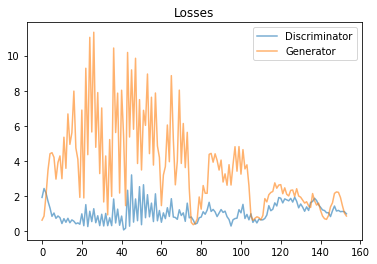

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

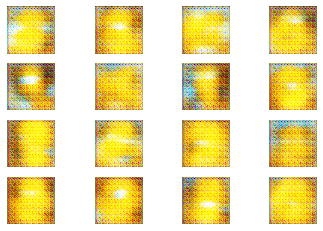

  2%|▏         | 1/50 [01:14<1:00:29, 74.07s/it]

Epoch: 2/50 | Step: 1/154 [D loss: 1.0166, acc.: 36.72%] [G loss: 0.7809]
Epoch: 2/50 | Step: 2/154 [D loss: 1.2693, acc.: 19.53%] [G loss: 1.1590]
Epoch: 2/50 | Step: 3/154 [D loss: 1.2040, acc.: 29.69%] [G loss: 1.4582]
Epoch: 2/50 | Step: 4/154 [D loss: 1.0722, acc.: 32.81%] [G loss: 1.3607]
Epoch: 2/50 | Step: 5/154 [D loss: 1.3383, acc.: 23.44%] [G loss: 1.7175]
Epoch: 2/50 | Step: 6/154 [D loss: 1.1162, acc.: 27.34%] [G loss: 1.7241]
Epoch: 2/50 | Step: 7/154 [D loss: 1.2095, acc.: 24.22%] [G loss: 1.6226]
Epoch: 2/50 | Step: 8/154 [D loss: 1.3021, acc.: 24.22%] [G loss: 1.6416]
Epoch: 2/50 | Step: 9/154 [D loss: 1.1842, acc.: 25.78%] [G loss: 1.6683]
Epoch: 2/50 | Step: 10/154 [D loss: 1.0983, acc.: 35.94%] [G loss: 1.3385]
Epoch: 2/50 | Step: 11/154 [D loss: 1.2292, acc.: 21.09%] [G loss: 1.3463]
Epoch: 2/50 | Step: 12/154 [D loss: 1.1123, acc.: 22.66%] [G loss: 1.6923]
Epoch: 2/50 | Step: 13/154 [D loss: 1.0699, acc.: 31.25%] [G loss: 1.5348]
Epoch: 2/50 | Step: 14/154 [D loss

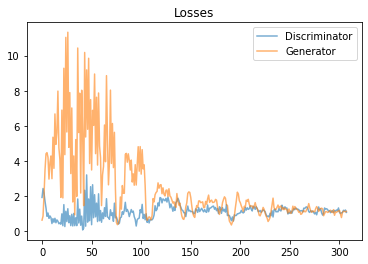

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

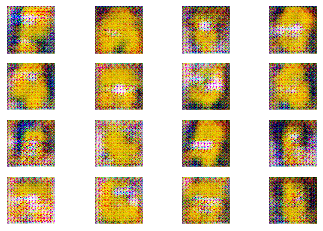

  4%|▍         | 2/50 [02:16<56:24, 70.51s/it]  

Epoch: 3/50 | Step: 1/154 [D loss: 1.3065, acc.: 8.59%] [G loss: 1.0156]
Epoch: 3/50 | Step: 2/154 [D loss: 1.0444, acc.: 26.56%] [G loss: 1.2102]
Epoch: 3/50 | Step: 3/154 [D loss: 1.2117, acc.: 23.44%] [G loss: 1.1418]
Epoch: 3/50 | Step: 4/154 [D loss: 1.2509, acc.: 19.53%] [G loss: 1.0523]
Epoch: 3/50 | Step: 5/154 [D loss: 0.9867, acc.: 25.78%] [G loss: 1.2208]
Epoch: 3/50 | Step: 6/154 [D loss: 1.2343, acc.: 8.59%] [G loss: 0.9447]
Epoch: 3/50 | Step: 7/154 [D loss: 1.2067, acc.: 10.16%] [G loss: 1.0659]
Epoch: 3/50 | Step: 8/154 [D loss: 1.2709, acc.: 7.81%] [G loss: 1.0644]
Epoch: 3/50 | Step: 9/154 [D loss: 1.0308, acc.: 20.31%] [G loss: 1.0995]
Epoch: 3/50 | Step: 10/154 [D loss: 1.1207, acc.: 21.09%] [G loss: 1.1208]
Epoch: 3/50 | Step: 11/154 [D loss: 1.1977, acc.: 10.94%] [G loss: 0.9739]
Epoch: 3/50 | Step: 12/154 [D loss: 1.0911, acc.: 16.41%] [G loss: 1.0116]
Epoch: 3/50 | Step: 13/154 [D loss: 1.2157, acc.: 10.94%] [G loss: 0.9037]
Epoch: 3/50 | Step: 14/154 [D loss: 1

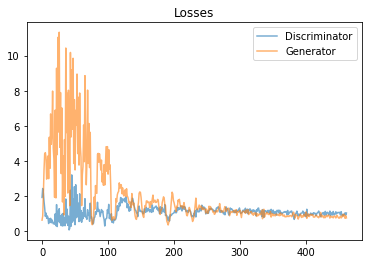

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

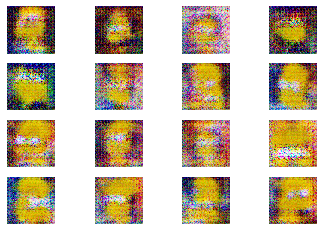

  6%|▌         | 3/50 [03:18<53:14, 67.96s/it]

Epoch: 4/50 | Step: 1/154 [D loss: 0.9487, acc.: 18.75%] [G loss: 0.7635]
Epoch: 4/50 | Step: 2/154 [D loss: 0.9877, acc.: 14.06%] [G loss: 0.8562]
Epoch: 4/50 | Step: 3/154 [D loss: 0.9056, acc.: 20.31%] [G loss: 0.9163]
Epoch: 4/50 | Step: 4/154 [D loss: 0.9794, acc.: 14.06%] [G loss: 0.8100]
Epoch: 4/50 | Step: 5/154 [D loss: 1.0307, acc.: 10.94%] [G loss: 0.7944]
Epoch: 4/50 | Step: 6/154 [D loss: 1.0072, acc.: 11.72%] [G loss: 0.8483]
Epoch: 4/50 | Step: 7/154 [D loss: 1.0904, acc.: 5.47%] [G loss: 0.7400]
Epoch: 4/50 | Step: 8/154 [D loss: 1.0020, acc.: 10.16%] [G loss: 0.8264]
Epoch: 4/50 | Step: 9/154 [D loss: 0.8715, acc.: 21.09%] [G loss: 0.8365]
Epoch: 4/50 | Step: 10/154 [D loss: 0.9010, acc.: 24.22%] [G loss: 0.8013]
Epoch: 4/50 | Step: 11/154 [D loss: 0.9182, acc.: 19.53%] [G loss: 0.7557]
Epoch: 4/50 | Step: 12/154 [D loss: 0.9756, acc.: 14.06%] [G loss: 0.8249]
Epoch: 4/50 | Step: 13/154 [D loss: 0.9419, acc.: 20.31%] [G loss: 0.8308]
Epoch: 4/50 | Step: 14/154 [D loss:

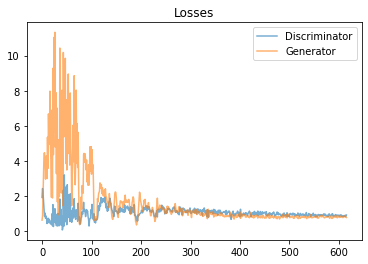

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

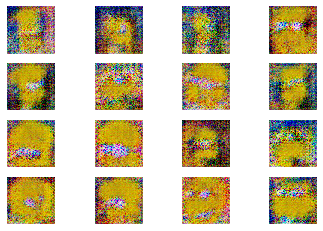

  8%|▊         | 4/50 [04:20<50:44, 66.19s/it]

Epoch: 5/50 | Step: 1/154 [D loss: 0.8600, acc.: 30.47%] [G loss: 0.8580]
Epoch: 5/50 | Step: 2/154 [D loss: 0.9449, acc.: 19.53%] [G loss: 0.7652]
Epoch: 5/50 | Step: 3/154 [D loss: 0.8861, acc.: 21.88%] [G loss: 0.8395]
Epoch: 5/50 | Step: 4/154 [D loss: 0.8631, acc.: 21.88%] [G loss: 0.8692]
Epoch: 5/50 | Step: 5/154 [D loss: 0.9013, acc.: 22.66%] [G loss: 0.7715]
Epoch: 5/50 | Step: 6/154 [D loss: 0.9578, acc.: 12.50%] [G loss: 0.7531]
Epoch: 5/50 | Step: 7/154 [D loss: 0.9631, acc.: 10.94%] [G loss: 0.7596]
Epoch: 5/50 | Step: 8/154 [D loss: 0.9350, acc.: 18.75%] [G loss: 0.7763]
Epoch: 5/50 | Step: 9/154 [D loss: 0.8123, acc.: 28.91%] [G loss: 0.9232]
Epoch: 5/50 | Step: 10/154 [D loss: 0.8415, acc.: 27.34%] [G loss: 0.8858]
Epoch: 5/50 | Step: 11/154 [D loss: 0.8648, acc.: 23.44%] [G loss: 0.8702]
Epoch: 5/50 | Step: 12/154 [D loss: 0.8976, acc.: 22.66%] [G loss: 0.8403]
Epoch: 5/50 | Step: 13/154 [D loss: 0.8624, acc.: 26.56%] [G loss: 0.8799]
Epoch: 5/50 | Step: 14/154 [D loss

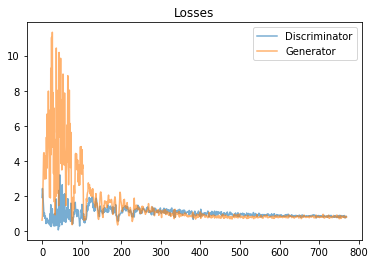

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

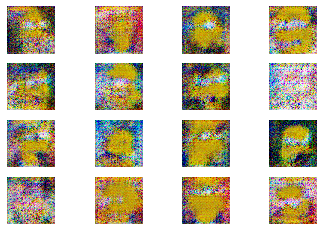

 10%|█         | 5/50 [05:22<48:43, 64.97s/it]

Epoch: 6/50 | Step: 1/154 [D loss: 0.8812, acc.: 19.53%] [G loss: 0.8005]
Epoch: 6/50 | Step: 2/154 [D loss: 0.8347, acc.: 25.78%] [G loss: 0.7965]
Epoch: 6/50 | Step: 3/154 [D loss: 0.9139, acc.: 10.16%] [G loss: 0.7564]
Epoch: 6/50 | Step: 4/154 [D loss: 0.8892, acc.: 18.75%] [G loss: 0.7527]
Epoch: 6/50 | Step: 5/154 [D loss: 0.8690, acc.: 14.84%] [G loss: 0.7644]
Epoch: 6/50 | Step: 6/154 [D loss: 0.8751, acc.: 17.19%] [G loss: 0.7454]
Epoch: 6/50 | Step: 7/154 [D loss: 0.9040, acc.: 14.84%] [G loss: 0.7592]
Epoch: 6/50 | Step: 8/154 [D loss: 0.8392, acc.: 23.44%] [G loss: 0.7909]
Epoch: 6/50 | Step: 9/154 [D loss: 0.8184, acc.: 28.91%] [G loss: 0.8921]
Epoch: 6/50 | Step: 10/154 [D loss: 0.8021, acc.: 26.56%] [G loss: 0.8581]
Epoch: 6/50 | Step: 11/154 [D loss: 0.8530, acc.: 25.00%] [G loss: 0.8080]
Epoch: 6/50 | Step: 12/154 [D loss: 0.8536, acc.: 16.41%] [G loss: 0.7474]
Epoch: 6/50 | Step: 13/154 [D loss: 0.8154, acc.: 25.78%] [G loss: 0.8064]
Epoch: 6/50 | Step: 14/154 [D loss

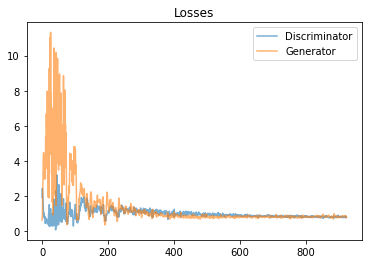

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

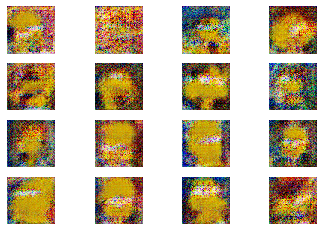

 12%|█▏        | 6/50 [06:24<47:01, 64.13s/it]

Epoch: 7/50 | Step: 1/154 [D loss: 0.7643, acc.: 34.38%] [G loss: 0.9335]
Epoch: 7/50 | Step: 2/154 [D loss: 0.7857, acc.: 34.38%] [G loss: 0.8099]
Epoch: 7/50 | Step: 3/154 [D loss: 0.8619, acc.: 19.53%] [G loss: 0.7748]
Epoch: 7/50 | Step: 4/154 [D loss: 0.8140, acc.: 27.34%] [G loss: 0.8169]
Epoch: 7/50 | Step: 5/154 [D loss: 0.7841, acc.: 34.38%] [G loss: 0.8338]
Epoch: 7/50 | Step: 6/154 [D loss: 0.8423, acc.: 23.44%] [G loss: 0.8079]
Epoch: 7/50 | Step: 7/154 [D loss: 0.8121, acc.: 25.78%] [G loss: 0.8144]
Epoch: 7/50 | Step: 8/154 [D loss: 0.8073, acc.: 28.12%] [G loss: 0.8473]
Epoch: 7/50 | Step: 9/154 [D loss: 0.8093, acc.: 20.31%] [G loss: 0.8157]
Epoch: 7/50 | Step: 10/154 [D loss: 0.8252, acc.: 25.78%] [G loss: 0.8593]
Epoch: 7/50 | Step: 11/154 [D loss: 0.7865, acc.: 33.59%] [G loss: 0.8749]
Epoch: 7/50 | Step: 12/154 [D loss: 0.7622, acc.: 35.94%] [G loss: 0.8474]
Epoch: 7/50 | Step: 13/154 [D loss: 0.7576, acc.: 40.62%] [G loss: 0.8704]
Epoch: 7/50 | Step: 14/154 [D loss

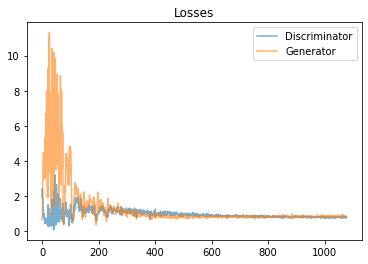

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

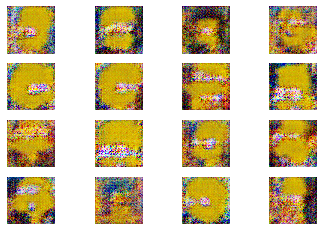

 14%|█▍        | 7/50 [07:27<45:35, 63.61s/it]

Epoch: 8/50 | Step: 1/154 [D loss: 0.8058, acc.: 28.12%] [G loss: 0.8222]
Epoch: 8/50 | Step: 2/154 [D loss: 0.7940, acc.: 29.69%] [G loss: 0.8278]
Epoch: 8/50 | Step: 3/154 [D loss: 0.7613, acc.: 41.41%] [G loss: 0.8237]
Epoch: 8/50 | Step: 4/154 [D loss: 0.7448, acc.: 42.97%] [G loss: 0.9226]
Epoch: 8/50 | Step: 5/154 [D loss: 0.7322, acc.: 43.75%] [G loss: 0.8584]
Epoch: 8/50 | Step: 6/154 [D loss: 0.7810, acc.: 35.16%] [G loss: 0.8542]
Epoch: 8/50 | Step: 7/154 [D loss: 0.7723, acc.: 32.81%] [G loss: 0.8353]
Epoch: 8/50 | Step: 8/154 [D loss: 0.7501, acc.: 43.75%] [G loss: 0.7995]
Epoch: 8/50 | Step: 9/154 [D loss: 0.7922, acc.: 36.72%] [G loss: 0.7985]
Epoch: 8/50 | Step: 10/154 [D loss: 0.7878, acc.: 33.59%] [G loss: 0.7697]
Epoch: 8/50 | Step: 11/154 [D loss: 0.7786, acc.: 29.69%] [G loss: 0.8577]
Epoch: 8/50 | Step: 12/154 [D loss: 0.8177, acc.: 21.09%] [G loss: 0.8223]
Epoch: 8/50 | Step: 13/154 [D loss: 0.7998, acc.: 27.34%] [G loss: 0.8443]
Epoch: 8/50 | Step: 14/154 [D loss

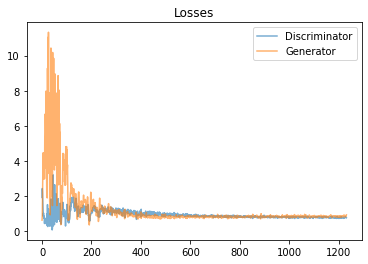

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

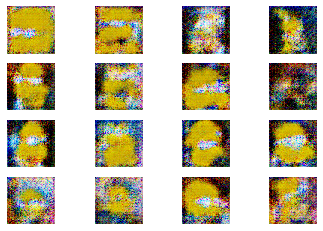

 16%|█▌        | 8/50 [08:29<44:12, 63.16s/it]

Epoch: 9/50 | Step: 1/154 [D loss: 0.7575, acc.: 46.88%] [G loss: 0.9243]
Epoch: 9/50 | Step: 2/154 [D loss: 0.7388, acc.: 46.88%] [G loss: 0.9130]
Epoch: 9/50 | Step: 3/154 [D loss: 0.7588, acc.: 37.50%] [G loss: 0.8457]
Epoch: 9/50 | Step: 4/154 [D loss: 0.7745, acc.: 39.84%] [G loss: 0.8321]
Epoch: 9/50 | Step: 5/154 [D loss: 0.8081, acc.: 32.03%] [G loss: 0.8438]
Epoch: 9/50 | Step: 6/154 [D loss: 0.7394, acc.: 46.88%] [G loss: 0.8762]
Epoch: 9/50 | Step: 7/154 [D loss: 0.7977, acc.: 25.78%] [G loss: 0.8589]
Epoch: 9/50 | Step: 8/154 [D loss: 0.7627, acc.: 39.06%] [G loss: 0.8914]
Epoch: 9/50 | Step: 9/154 [D loss: 0.8160, acc.: 30.47%] [G loss: 0.7629]
Epoch: 9/50 | Step: 10/154 [D loss: 0.7617, acc.: 43.75%] [G loss: 0.8076]
Epoch: 9/50 | Step: 11/154 [D loss: 0.7706, acc.: 39.06%] [G loss: 0.8401]
Epoch: 9/50 | Step: 12/154 [D loss: 0.7461, acc.: 35.94%] [G loss: 0.8378]
Epoch: 9/50 | Step: 13/154 [D loss: 0.7505, acc.: 34.38%] [G loss: 0.8233]
Epoch: 9/50 | Step: 14/154 [D loss

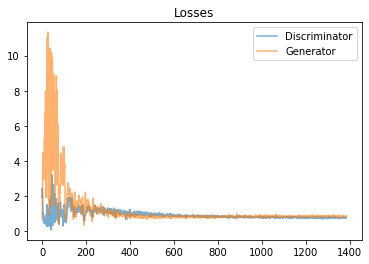

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

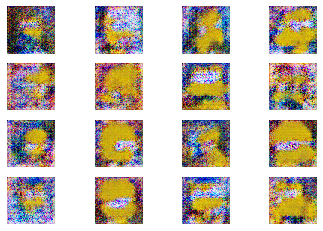

 18%|█▊        | 9/50 [09:31<42:57, 62.85s/it]

Epoch: 10/50 | Step: 1/154 [D loss: 0.7568, acc.: 36.72%] [G loss: 0.8376]
Epoch: 10/50 | Step: 2/154 [D loss: 0.7762, acc.: 30.47%] [G loss: 0.8466]
Epoch: 10/50 | Step: 3/154 [D loss: 0.7883, acc.: 36.72%] [G loss: 0.7952]
Epoch: 10/50 | Step: 4/154 [D loss: 0.7941, acc.: 37.50%] [G loss: 0.8421]
Epoch: 10/50 | Step: 5/154 [D loss: 0.7754, acc.: 33.59%] [G loss: 0.8904]
Epoch: 10/50 | Step: 6/154 [D loss: 0.7497, acc.: 33.59%] [G loss: 0.8207]
Epoch: 10/50 | Step: 7/154 [D loss: 0.7719, acc.: 36.72%] [G loss: 0.8037]
Epoch: 10/50 | Step: 8/154 [D loss: 0.7664, acc.: 34.38%] [G loss: 0.8000]
Epoch: 10/50 | Step: 9/154 [D loss: 0.7422, acc.: 40.62%] [G loss: 0.8756]
Epoch: 10/50 | Step: 10/154 [D loss: 0.7836, acc.: 36.72%] [G loss: 0.8745]
Epoch: 10/50 | Step: 11/154 [D loss: 0.7506, acc.: 35.16%] [G loss: 0.8465]
Epoch: 10/50 | Step: 12/154 [D loss: 0.7557, acc.: 34.38%] [G loss: 0.8865]
Epoch: 10/50 | Step: 13/154 [D loss: 0.7528, acc.: 44.53%] [G loss: 0.8363]
Epoch: 10/50 | Step: 

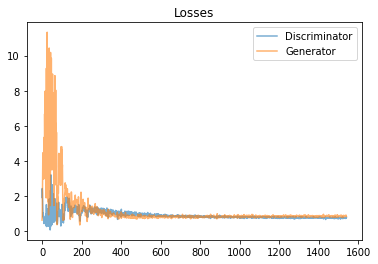

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

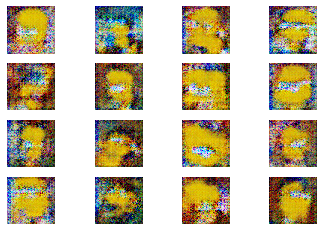

 20%|██        | 10/50 [10:34<42:03, 63.08s/it]

Epoch: 11/50 | Step: 1/154 [D loss: 0.7380, acc.: 42.97%] [G loss: 0.8813]
Epoch: 11/50 | Step: 2/154 [D loss: 0.7689, acc.: 37.50%] [G loss: 0.8745]
Epoch: 11/50 | Step: 3/154 [D loss: 0.7360, acc.: 41.41%] [G loss: 0.8400]
Epoch: 11/50 | Step: 4/154 [D loss: 0.7658, acc.: 38.28%] [G loss: 0.8578]
Epoch: 11/50 | Step: 5/154 [D loss: 0.8422, acc.: 25.00%] [G loss: 0.7495]
Epoch: 11/50 | Step: 6/154 [D loss: 0.7868, acc.: 33.59%] [G loss: 0.8196]
Epoch: 11/50 | Step: 7/154 [D loss: 0.7424, acc.: 35.16%] [G loss: 0.9037]
Epoch: 11/50 | Step: 8/154 [D loss: 0.7631, acc.: 45.31%] [G loss: 0.8410]
Epoch: 11/50 | Step: 9/154 [D loss: 0.7880, acc.: 29.69%] [G loss: 0.8574]
Epoch: 11/50 | Step: 10/154 [D loss: 0.7803, acc.: 32.03%] [G loss: 0.8554]
Epoch: 11/50 | Step: 11/154 [D loss: 0.7499, acc.: 37.50%] [G loss: 0.9276]
Epoch: 11/50 | Step: 12/154 [D loss: 0.6880, acc.: 55.47%] [G loss: 0.9021]
Epoch: 11/50 | Step: 13/154 [D loss: 0.7533, acc.: 42.19%] [G loss: 0.8438]
Epoch: 11/50 | Step: 

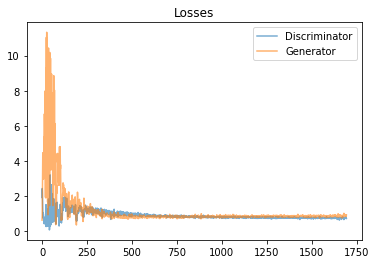

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

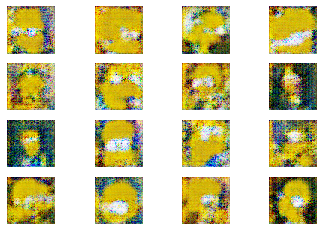

 22%|██▏       | 11/50 [11:37<40:53, 62.90s/it]

Epoch: 12/50 | Step: 1/154 [D loss: 0.7342, acc.: 43.75%] [G loss: 0.9193]
Epoch: 12/50 | Step: 2/154 [D loss: 0.7477, acc.: 48.44%] [G loss: 0.9404]
Epoch: 12/50 | Step: 3/154 [D loss: 0.7637, acc.: 37.50%] [G loss: 0.8475]
Epoch: 12/50 | Step: 4/154 [D loss: 0.7256, acc.: 42.97%] [G loss: 0.9069]
Epoch: 12/50 | Step: 5/154 [D loss: 0.7427, acc.: 42.97%] [G loss: 0.8366]
Epoch: 12/50 | Step: 6/154 [D loss: 0.6913, acc.: 55.47%] [G loss: 0.9134]
Epoch: 12/50 | Step: 7/154 [D loss: 0.7045, acc.: 53.12%] [G loss: 0.8604]
Epoch: 12/50 | Step: 8/154 [D loss: 0.7510, acc.: 45.31%] [G loss: 0.8481]
Epoch: 12/50 | Step: 9/154 [D loss: 0.7947, acc.: 42.19%] [G loss: 0.8501]
Epoch: 12/50 | Step: 10/154 [D loss: 0.7181, acc.: 41.41%] [G loss: 0.9462]
Epoch: 12/50 | Step: 11/154 [D loss: 0.7763, acc.: 42.97%] [G loss: 0.8194]
Epoch: 12/50 | Step: 12/154 [D loss: 0.7416, acc.: 40.62%] [G loss: 0.9833]
Epoch: 12/50 | Step: 13/154 [D loss: 0.7538, acc.: 46.88%] [G loss: 0.8444]
Epoch: 12/50 | Step: 

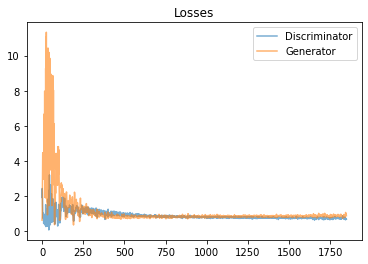

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

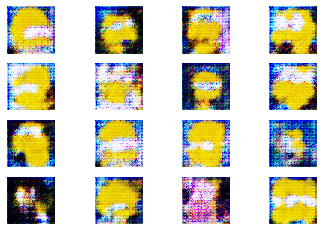

 24%|██▍       | 12/50 [12:39<39:40, 62.64s/it]

Epoch: 13/50 | Step: 1/154 [D loss: 0.6768, acc.: 56.25%] [G loss: 0.8796]
Epoch: 13/50 | Step: 2/154 [D loss: 0.7317, acc.: 39.06%] [G loss: 0.8385]
Epoch: 13/50 | Step: 3/154 [D loss: 0.7295, acc.: 46.88%] [G loss: 0.8517]
Epoch: 13/50 | Step: 4/154 [D loss: 0.6769, acc.: 55.47%] [G loss: 0.8755]
Epoch: 13/50 | Step: 5/154 [D loss: 0.6960, acc.: 55.47%] [G loss: 0.9287]
Epoch: 13/50 | Step: 6/154 [D loss: 0.6997, acc.: 50.78%] [G loss: 0.9603]
Epoch: 13/50 | Step: 7/154 [D loss: 0.7399, acc.: 46.09%] [G loss: 0.8755]
Epoch: 13/50 | Step: 8/154 [D loss: 0.7537, acc.: 47.66%] [G loss: 0.8692]
Epoch: 13/50 | Step: 9/154 [D loss: 0.7243, acc.: 44.53%] [G loss: 0.8735]
Epoch: 13/50 | Step: 10/154 [D loss: 0.6722, acc.: 56.25%] [G loss: 0.8843]
Epoch: 13/50 | Step: 11/154 [D loss: 0.6927, acc.: 54.69%] [G loss: 0.8947]
Epoch: 13/50 | Step: 12/154 [D loss: 0.7241, acc.: 45.31%] [G loss: 0.8553]
Epoch: 13/50 | Step: 13/154 [D loss: 0.6973, acc.: 51.56%] [G loss: 0.8361]
Epoch: 13/50 | Step: 

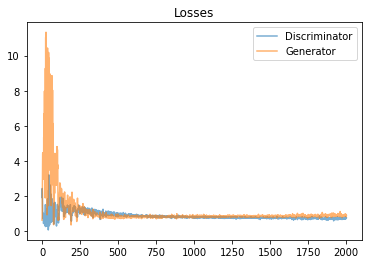

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

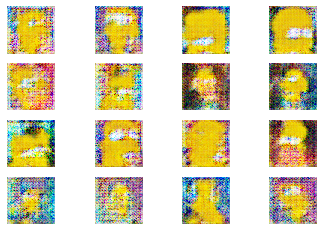

 26%|██▌       | 13/50 [13:41<38:30, 62.45s/it]

Epoch: 14/50 | Step: 1/154 [D loss: 0.7836, acc.: 34.38%] [G loss: 0.8635]
Epoch: 14/50 | Step: 2/154 [D loss: 0.7440, acc.: 43.75%] [G loss: 0.9211]
Epoch: 14/50 | Step: 3/154 [D loss: 0.7796, acc.: 33.59%] [G loss: 0.9173]
Epoch: 14/50 | Step: 4/154 [D loss: 0.6443, acc.: 57.81%] [G loss: 1.0206]
Epoch: 14/50 | Step: 5/154 [D loss: 0.7474, acc.: 46.09%] [G loss: 0.8411]
Epoch: 14/50 | Step: 6/154 [D loss: 0.7358, acc.: 46.09%] [G loss: 0.8795]
Epoch: 14/50 | Step: 7/154 [D loss: 0.7073, acc.: 56.25%] [G loss: 0.9394]
Epoch: 14/50 | Step: 8/154 [D loss: 0.7154, acc.: 50.00%] [G loss: 0.9117]
Epoch: 14/50 | Step: 9/154 [D loss: 0.7864, acc.: 33.59%] [G loss: 0.8658]
Epoch: 14/50 | Step: 10/154 [D loss: 0.7547, acc.: 41.41%] [G loss: 0.8601]
Epoch: 14/50 | Step: 11/154 [D loss: 0.7391, acc.: 46.88%] [G loss: 0.8969]
Epoch: 14/50 | Step: 12/154 [D loss: 0.7322, acc.: 44.53%] [G loss: 0.8822]
Epoch: 14/50 | Step: 13/154 [D loss: 0.7173, acc.: 50.00%] [G loss: 0.8863]
Epoch: 14/50 | Step: 

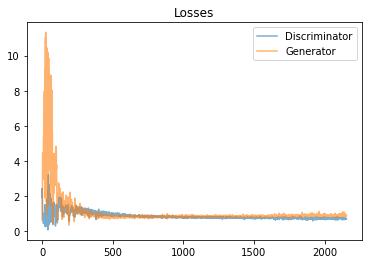

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

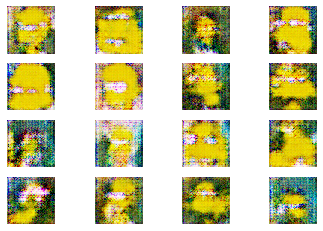

 28%|██▊       | 14/50 [14:43<37:24, 62.34s/it]

Epoch: 15/50 | Step: 1/154 [D loss: 0.7669, acc.: 53.12%] [G loss: 0.8984]
Epoch: 15/50 | Step: 2/154 [D loss: 0.7232, acc.: 46.88%] [G loss: 0.8498]
Epoch: 15/50 | Step: 3/154 [D loss: 0.7503, acc.: 41.41%] [G loss: 0.9230]
Epoch: 15/50 | Step: 4/154 [D loss: 0.7418, acc.: 53.12%] [G loss: 0.8726]
Epoch: 15/50 | Step: 5/154 [D loss: 0.7625, acc.: 43.75%] [G loss: 0.8628]
Epoch: 15/50 | Step: 6/154 [D loss: 0.7603, acc.: 37.50%] [G loss: 0.8701]
Epoch: 15/50 | Step: 7/154 [D loss: 0.7657, acc.: 38.28%] [G loss: 0.8925]
Epoch: 15/50 | Step: 8/154 [D loss: 0.6827, acc.: 61.72%] [G loss: 0.9490]
Epoch: 15/50 | Step: 9/154 [D loss: 0.7617, acc.: 40.62%] [G loss: 0.9226]
Epoch: 15/50 | Step: 10/154 [D loss: 0.7632, acc.: 42.19%] [G loss: 1.0221]
Epoch: 15/50 | Step: 11/154 [D loss: 0.6593, acc.: 60.94%] [G loss: 0.9557]
Epoch: 15/50 | Step: 12/154 [D loss: 0.7222, acc.: 47.66%] [G loss: 0.8468]
Epoch: 15/50 | Step: 13/154 [D loss: 0.7251, acc.: 44.53%] [G loss: 0.9325]
Epoch: 15/50 | Step: 

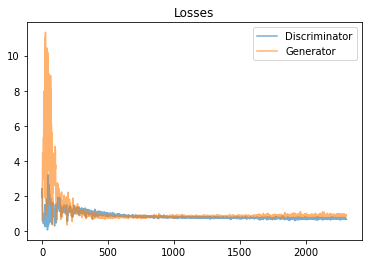

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

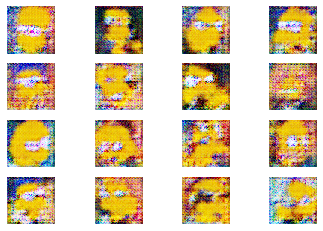

 30%|███       | 15/50 [15:45<36:21, 62.33s/it]

Epoch: 16/50 | Step: 1/154 [D loss: 0.7702, acc.: 39.06%] [G loss: 0.8409]
Epoch: 16/50 | Step: 2/154 [D loss: 0.7254, acc.: 44.53%] [G loss: 0.9382]
Epoch: 16/50 | Step: 3/154 [D loss: 0.6629, acc.: 58.59%] [G loss: 0.9496]
Epoch: 16/50 | Step: 4/154 [D loss: 0.6959, acc.: 56.25%] [G loss: 0.8910]
Epoch: 16/50 | Step: 5/154 [D loss: 0.6981, acc.: 55.47%] [G loss: 0.9554]
Epoch: 16/50 | Step: 6/154 [D loss: 0.7271, acc.: 46.88%] [G loss: 0.9322]
Epoch: 16/50 | Step: 7/154 [D loss: 0.7247, acc.: 47.66%] [G loss: 0.8816]
Epoch: 16/50 | Step: 8/154 [D loss: 0.7141, acc.: 52.34%] [G loss: 0.8589]
Epoch: 16/50 | Step: 9/154 [D loss: 0.7116, acc.: 48.44%] [G loss: 0.8817]
Epoch: 16/50 | Step: 10/154 [D loss: 0.7315, acc.: 43.75%] [G loss: 0.8766]
Epoch: 16/50 | Step: 11/154 [D loss: 0.6884, acc.: 53.12%] [G loss: 0.9377]
Epoch: 16/50 | Step: 12/154 [D loss: 0.6905, acc.: 56.25%] [G loss: 0.9593]
Epoch: 16/50 | Step: 13/154 [D loss: 0.6737, acc.: 54.69%] [G loss: 0.9513]
Epoch: 16/50 | Step: 

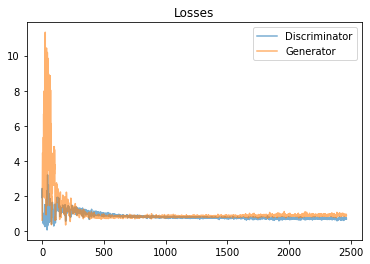

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

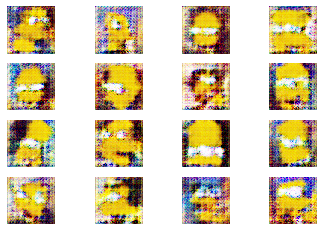

 32%|███▏      | 16/50 [16:47<35:15, 62.23s/it]

Epoch: 17/50 | Step: 1/154 [D loss: 0.7747, acc.: 40.62%] [G loss: 0.9000]
Epoch: 17/50 | Step: 2/154 [D loss: 0.6581, acc.: 64.06%] [G loss: 0.9724]
Epoch: 17/50 | Step: 3/154 [D loss: 0.6876, acc.: 52.34%] [G loss: 0.9193]
Epoch: 17/50 | Step: 4/154 [D loss: 0.6809, acc.: 64.84%] [G loss: 0.8525]
Epoch: 17/50 | Step: 5/154 [D loss: 0.6786, acc.: 54.69%] [G loss: 0.8705]
Epoch: 17/50 | Step: 6/154 [D loss: 0.6927, acc.: 55.47%] [G loss: 0.8504]
Epoch: 17/50 | Step: 7/154 [D loss: 0.7405, acc.: 39.84%] [G loss: 0.8443]
Epoch: 17/50 | Step: 8/154 [D loss: 0.7354, acc.: 43.75%] [G loss: 0.8596]
Epoch: 17/50 | Step: 9/154 [D loss: 0.6948, acc.: 53.12%] [G loss: 1.0013]
Epoch: 17/50 | Step: 10/154 [D loss: 0.6839, acc.: 57.81%] [G loss: 1.0536]
Epoch: 17/50 | Step: 11/154 [D loss: 0.6790, acc.: 53.91%] [G loss: 1.1205]
Epoch: 17/50 | Step: 12/154 [D loss: 0.6905, acc.: 56.25%] [G loss: 0.9915]
Epoch: 17/50 | Step: 13/154 [D loss: 0.7283, acc.: 53.12%] [G loss: 0.9326]
Epoch: 17/50 | Step: 

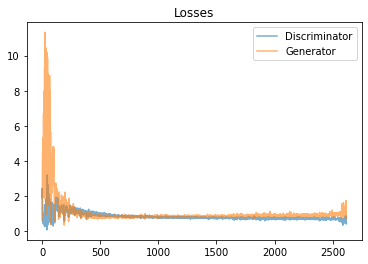

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

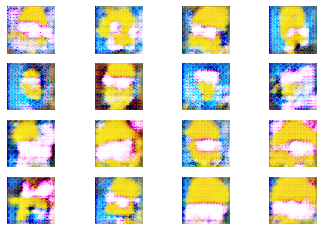

 34%|███▍      | 17/50 [17:49<34:12, 62.18s/it]

Epoch: 18/50 | Step: 1/154 [D loss: 0.4704, acc.: 85.16%] [G loss: 0.7344]
Epoch: 18/50 | Step: 2/154 [D loss: 0.5505, acc.: 74.22%] [G loss: 1.1014]
Epoch: 18/50 | Step: 3/154 [D loss: 0.4289, acc.: 89.84%] [G loss: 1.3253]
Epoch: 18/50 | Step: 4/154 [D loss: 0.4599, acc.: 86.72%] [G loss: 1.4960]
Epoch: 18/50 | Step: 5/154 [D loss: 0.7215, acc.: 50.78%] [G loss: 1.0705]
Epoch: 18/50 | Step: 6/154 [D loss: 0.4968, acc.: 85.94%] [G loss: 1.7809]
Epoch: 18/50 | Step: 7/154 [D loss: 0.4891, acc.: 72.66%] [G loss: 1.6691]
Epoch: 18/50 | Step: 8/154 [D loss: 0.4518, acc.: 92.19%] [G loss: 0.8076]
Epoch: 18/50 | Step: 9/154 [D loss: 0.5248, acc.: 75.78%] [G loss: 1.3319]
Epoch: 18/50 | Step: 10/154 [D loss: 0.8037, acc.: 42.97%] [G loss: 1.1624]
Epoch: 18/50 | Step: 11/154 [D loss: 0.5876, acc.: 71.09%] [G loss: 1.8154]
Epoch: 18/50 | Step: 12/154 [D loss: 0.3980, acc.: 81.25%] [G loss: 2.0417]
Epoch: 18/50 | Step: 13/154 [D loss: 0.5990, acc.: 62.50%] [G loss: 1.3578]
Epoch: 18/50 | Step: 

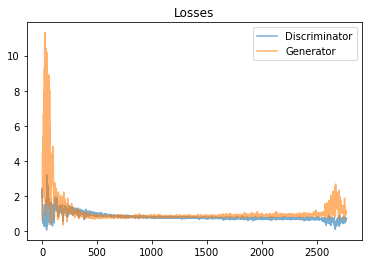

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

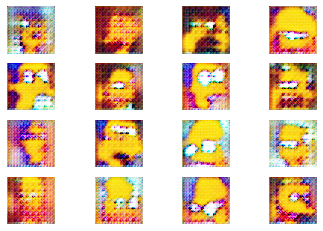

 36%|███▌      | 18/50 [18:51<33:08, 62.15s/it]

Epoch: 19/50 | Step: 1/154 [D loss: 0.5486, acc.: 80.47%] [G loss: 1.0515]
Epoch: 19/50 | Step: 2/154 [D loss: 0.5640, acc.: 66.41%] [G loss: 0.9415]
Epoch: 19/50 | Step: 3/154 [D loss: 0.5617, acc.: 75.00%] [G loss: 0.8852]
Epoch: 19/50 | Step: 4/154 [D loss: 0.4134, acc.: 85.94%] [G loss: 0.7078]
Epoch: 19/50 | Step: 5/154 [D loss: 0.7548, acc.: 53.91%] [G loss: 0.8123]
Epoch: 19/50 | Step: 6/154 [D loss: 0.5107, acc.: 82.81%] [G loss: 1.1344]
Epoch: 19/50 | Step: 7/154 [D loss: 0.5859, acc.: 68.75%] [G loss: 1.1458]
Epoch: 19/50 | Step: 8/154 [D loss: 0.4772, acc.: 80.47%] [G loss: 1.8085]
Epoch: 19/50 | Step: 9/154 [D loss: 0.6392, acc.: 64.84%] [G loss: 1.1942]
Epoch: 19/50 | Step: 10/154 [D loss: 0.5336, acc.: 73.44%] [G loss: 1.0350]
Epoch: 19/50 | Step: 11/154 [D loss: 0.3782, acc.: 90.62%] [G loss: 0.9643]
Epoch: 19/50 | Step: 12/154 [D loss: 0.7544, acc.: 53.12%] [G loss: 1.0150]
Epoch: 19/50 | Step: 13/154 [D loss: 0.6714, acc.: 59.38%] [G loss: 0.9068]
Epoch: 19/50 | Step: 

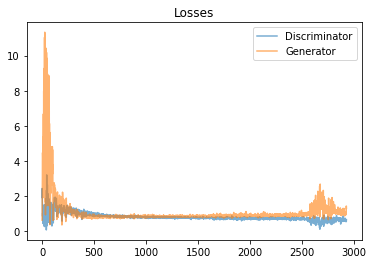

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

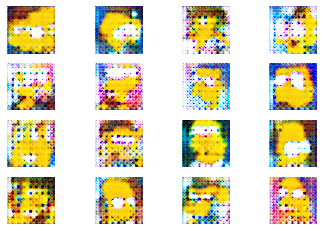

 38%|███▊      | 19/50 [19:54<32:09, 62.24s/it]

Epoch: 20/50 | Step: 1/154 [D loss: 0.5685, acc.: 77.34%] [G loss: 1.0664]
Epoch: 20/50 | Step: 2/154 [D loss: 0.5181, acc.: 81.25%] [G loss: 0.9436]
Epoch: 20/50 | Step: 3/154 [D loss: 0.6266, acc.: 61.72%] [G loss: 1.0745]
Epoch: 20/50 | Step: 4/154 [D loss: 0.4911, acc.: 83.59%] [G loss: 1.1507]
Epoch: 20/50 | Step: 5/154 [D loss: 0.7391, acc.: 52.34%] [G loss: 1.1996]
Epoch: 20/50 | Step: 6/154 [D loss: 0.5517, acc.: 70.31%] [G loss: 1.0576]
Epoch: 20/50 | Step: 7/154 [D loss: 0.6204, acc.: 64.06%] [G loss: 0.9990]
Epoch: 20/50 | Step: 8/154 [D loss: 0.7656, acc.: 46.09%] [G loss: 1.1890]
Epoch: 20/50 | Step: 9/154 [D loss: 0.7710, acc.: 42.19%] [G loss: 1.0894]
Epoch: 20/50 | Step: 10/154 [D loss: 0.7029, acc.: 55.47%] [G loss: 1.0512]
Epoch: 20/50 | Step: 11/154 [D loss: 0.6493, acc.: 66.41%] [G loss: 1.1849]
Epoch: 20/50 | Step: 12/154 [D loss: 0.7589, acc.: 49.22%] [G loss: 1.1691]
Epoch: 20/50 | Step: 13/154 [D loss: 0.6779, acc.: 58.59%] [G loss: 0.9778]
Epoch: 20/50 | Step: 

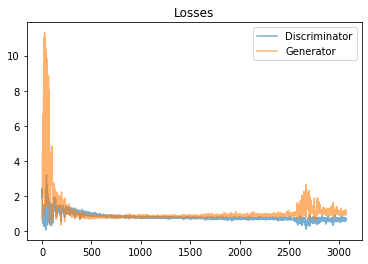

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

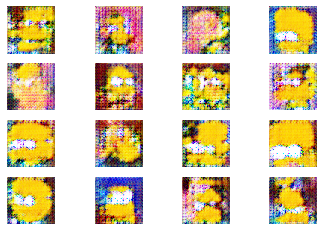

 40%|████      | 20/50 [20:56<31:08, 62.30s/it]

Epoch: 21/50 | Step: 1/154 [D loss: 0.7271, acc.: 45.31%] [G loss: 1.0202]
Epoch: 21/50 | Step: 2/154 [D loss: 0.6467, acc.: 64.84%] [G loss: 1.1631]
Epoch: 21/50 | Step: 3/154 [D loss: 0.6551, acc.: 60.16%] [G loss: 0.9956]
Epoch: 21/50 | Step: 4/154 [D loss: 0.7561, acc.: 45.31%] [G loss: 1.0171]
Epoch: 21/50 | Step: 5/154 [D loss: 0.7610, acc.: 42.19%] [G loss: 0.9435]
Epoch: 21/50 | Step: 6/154 [D loss: 0.5960, acc.: 69.53%] [G loss: 1.1763]
Epoch: 21/50 | Step: 7/154 [D loss: 0.6428, acc.: 61.72%] [G loss: 1.2288]
Epoch: 21/50 | Step: 8/154 [D loss: 0.6934, acc.: 56.25%] [G loss: 1.2063]
Epoch: 21/50 | Step: 9/154 [D loss: 0.7989, acc.: 46.88%] [G loss: 1.0002]
Epoch: 21/50 | Step: 10/154 [D loss: 0.7025, acc.: 55.47%] [G loss: 1.0146]
Epoch: 21/50 | Step: 11/154 [D loss: 0.6177, acc.: 63.28%] [G loss: 1.1032]
Epoch: 21/50 | Step: 12/154 [D loss: 0.7060, acc.: 60.16%] [G loss: 0.9584]
Epoch: 21/50 | Step: 13/154 [D loss: 0.6966, acc.: 53.12%] [G loss: 1.0069]
Epoch: 21/50 | Step: 

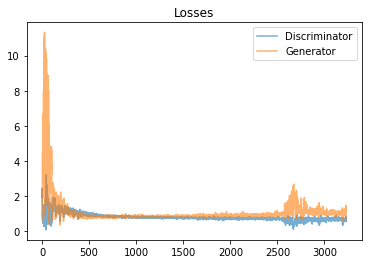

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

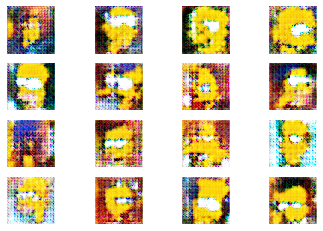

 42%|████▏     | 21/50 [21:58<30:04, 62.24s/it]

Epoch: 22/50 | Step: 1/154 [D loss: 0.6964, acc.: 57.03%] [G loss: 1.1835]
Epoch: 22/50 | Step: 2/154 [D loss: 0.6650, acc.: 61.72%] [G loss: 1.1429]
Epoch: 22/50 | Step: 3/154 [D loss: 0.6456, acc.: 58.59%] [G loss: 1.1736]
Epoch: 22/50 | Step: 4/154 [D loss: 0.6725, acc.: 60.16%] [G loss: 1.0620]
Epoch: 22/50 | Step: 5/154 [D loss: 0.6489, acc.: 62.50%] [G loss: 1.0862]
Epoch: 22/50 | Step: 6/154 [D loss: 0.6277, acc.: 68.75%] [G loss: 0.9544]
Epoch: 22/50 | Step: 7/154 [D loss: 0.6793, acc.: 59.38%] [G loss: 0.9136]
Epoch: 22/50 | Step: 8/154 [D loss: 0.6290, acc.: 64.84%] [G loss: 0.9195]
Epoch: 22/50 | Step: 9/154 [D loss: 0.6299, acc.: 68.75%] [G loss: 1.0964]
Epoch: 22/50 | Step: 10/154 [D loss: 0.6668, acc.: 59.38%] [G loss: 1.7385]
Epoch: 22/50 | Step: 11/154 [D loss: 0.6059, acc.: 69.53%] [G loss: 1.7081]
Epoch: 22/50 | Step: 12/154 [D loss: 0.6416, acc.: 57.81%] [G loss: 1.0052]
Epoch: 22/50 | Step: 13/154 [D loss: 0.4398, acc.: 88.28%] [G loss: 1.3573]
Epoch: 22/50 | Step: 

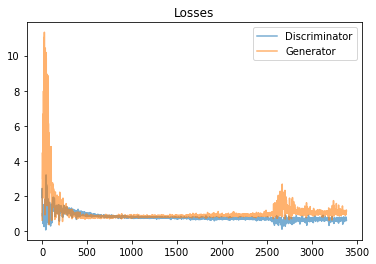

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

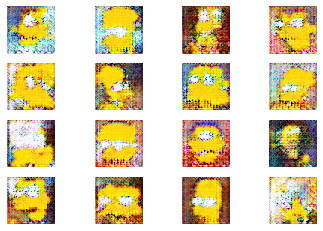

 44%|████▍     | 22/50 [23:01<29:01, 62.20s/it]

Epoch: 23/50 | Step: 1/154 [D loss: 0.7620, acc.: 45.31%] [G loss: 1.0565]
Epoch: 23/50 | Step: 2/154 [D loss: 0.7557, acc.: 51.56%] [G loss: 0.9616]
Epoch: 23/50 | Step: 3/154 [D loss: 0.7621, acc.: 47.66%] [G loss: 1.0037]
Epoch: 23/50 | Step: 4/154 [D loss: 0.6120, acc.: 64.84%] [G loss: 0.9165]
Epoch: 23/50 | Step: 5/154 [D loss: 0.6863, acc.: 52.34%] [G loss: 1.0392]
Epoch: 23/50 | Step: 6/154 [D loss: 0.4412, acc.: 80.47%] [G loss: 1.0141]
Epoch: 23/50 | Step: 7/154 [D loss: 0.6935, acc.: 50.78%] [G loss: 1.0369]
Epoch: 23/50 | Step: 8/154 [D loss: 0.6849, acc.: 52.34%] [G loss: 1.0875]
Epoch: 23/50 | Step: 9/154 [D loss: 0.6029, acc.: 67.19%] [G loss: 1.1259]
Epoch: 23/50 | Step: 10/154 [D loss: 0.5514, acc.: 75.00%] [G loss: 1.2437]
Epoch: 23/50 | Step: 11/154 [D loss: 0.6718, acc.: 60.16%] [G loss: 1.0672]
Epoch: 23/50 | Step: 12/154 [D loss: 0.5752, acc.: 71.88%] [G loss: 1.1261]
Epoch: 23/50 | Step: 13/154 [D loss: 0.5943, acc.: 70.31%] [G loss: 1.1097]
Epoch: 23/50 | Step: 

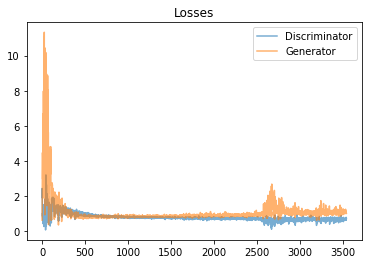

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

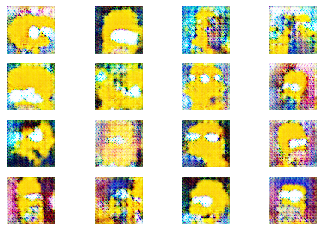

 46%|████▌     | 23/50 [24:03<28:00, 62.26s/it]

Epoch: 24/50 | Step: 1/154 [D loss: 0.6086, acc.: 67.19%] [G loss: 1.0948]
Epoch: 24/50 | Step: 2/154 [D loss: 0.6773, acc.: 56.25%] [G loss: 1.2036]
Epoch: 24/50 | Step: 3/154 [D loss: 0.7110, acc.: 51.56%] [G loss: 1.1817]
Epoch: 24/50 | Step: 4/154 [D loss: 0.6236, acc.: 66.41%] [G loss: 0.9869]
Epoch: 24/50 | Step: 5/154 [D loss: 0.7381, acc.: 50.00%] [G loss: 0.9270]
Epoch: 24/50 | Step: 6/154 [D loss: 0.6998, acc.: 55.47%] [G loss: 1.0376]
Epoch: 24/50 | Step: 7/154 [D loss: 0.6884, acc.: 58.59%] [G loss: 0.9947]
Epoch: 24/50 | Step: 8/154 [D loss: 0.6317, acc.: 63.28%] [G loss: 1.0875]
Epoch: 24/50 | Step: 9/154 [D loss: 0.6823, acc.: 54.69%] [G loss: 0.9765]
Epoch: 24/50 | Step: 10/154 [D loss: 0.5916, acc.: 69.53%] [G loss: 1.0334]
Epoch: 24/50 | Step: 11/154 [D loss: 0.5072, acc.: 80.47%] [G loss: 1.0055]
Epoch: 24/50 | Step: 12/154 [D loss: 0.6138, acc.: 67.97%] [G loss: 0.8373]
Epoch: 24/50 | Step: 13/154 [D loss: 0.6189, acc.: 59.38%] [G loss: 0.9596]
Epoch: 24/50 | Step: 

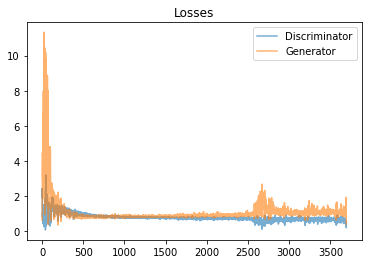

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

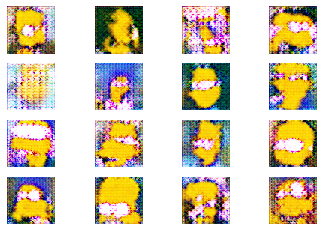

 48%|████▊     | 24/50 [25:05<26:56, 62.19s/it]

Epoch: 25/50 | Step: 1/154 [D loss: 0.4036, acc.: 86.72%] [G loss: 0.9215]
Epoch: 25/50 | Step: 2/154 [D loss: 0.8890, acc.: 38.28%] [G loss: 1.1100]
Epoch: 25/50 | Step: 3/154 [D loss: 0.6352, acc.: 65.62%] [G loss: 1.2749]
Epoch: 25/50 | Step: 4/154 [D loss: 0.5790, acc.: 70.31%] [G loss: 1.4673]
Epoch: 25/50 | Step: 5/154 [D loss: 0.4013, acc.: 85.16%] [G loss: 2.3698]
Epoch: 25/50 | Step: 6/154 [D loss: 0.3550, acc.: 92.97%] [G loss: 0.9704]
Epoch: 25/50 | Step: 7/154 [D loss: 0.4222, acc.: 91.41%] [G loss: 0.7774]
Epoch: 25/50 | Step: 8/154 [D loss: 0.7257, acc.: 51.56%] [G loss: 1.4216]
Epoch: 25/50 | Step: 9/154 [D loss: 0.4641, acc.: 80.47%] [G loss: 1.6627]
Epoch: 25/50 | Step: 10/154 [D loss: 0.3111, acc.: 86.72%] [G loss: 2.6577]
Epoch: 25/50 | Step: 11/154 [D loss: 0.5441, acc.: 67.19%] [G loss: 1.6523]
Epoch: 25/50 | Step: 12/154 [D loss: 0.3649, acc.: 90.62%] [G loss: 1.5450]
Epoch: 25/50 | Step: 13/154 [D loss: 0.4781, acc.: 82.81%] [G loss: 1.9477]
Epoch: 25/50 | Step: 

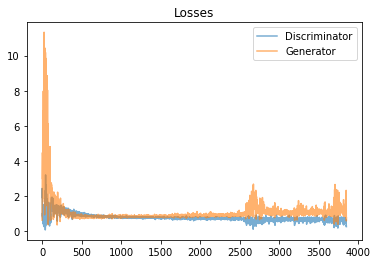

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

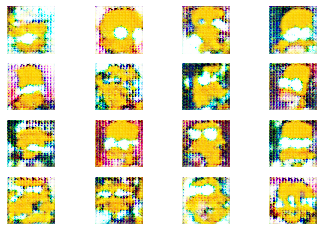

 50%|█████     | 25/50 [26:07<25:53, 62.16s/it]

Epoch: 26/50 | Step: 1/154 [D loss: 0.3876, acc.: 96.88%] [G loss: 0.9118]
Epoch: 26/50 | Step: 2/154 [D loss: 0.4820, acc.: 85.94%] [G loss: 2.2299]
Epoch: 26/50 | Step: 3/154 [D loss: 0.4399, acc.: 81.25%] [G loss: 0.6914]
Epoch: 26/50 | Step: 4/154 [D loss: 0.1800, acc.: 95.31%] [G loss: 0.3496]
Epoch: 26/50 | Step: 5/154 [D loss: 0.3955, acc.: 81.25%] [G loss: 1.0700]
Epoch: 26/50 | Step: 6/154 [D loss: 0.7361, acc.: 47.66%] [G loss: 1.6629]
Epoch: 26/50 | Step: 7/154 [D loss: 0.5980, acc.: 64.84%] [G loss: 1.4621]
Epoch: 26/50 | Step: 8/154 [D loss: 0.6730, acc.: 54.69%] [G loss: 1.9927]
Epoch: 26/50 | Step: 9/154 [D loss: 0.3949, acc.: 85.94%] [G loss: 1.9874]
Epoch: 26/50 | Step: 10/154 [D loss: 0.6000, acc.: 61.72%] [G loss: 1.5515]
Epoch: 26/50 | Step: 11/154 [D loss: 0.9554, acc.: 41.41%] [G loss: 1.2816]
Epoch: 26/50 | Step: 12/154 [D loss: 0.5127, acc.: 75.00%] [G loss: 1.1402]
Epoch: 26/50 | Step: 13/154 [D loss: 0.6399, acc.: 63.28%] [G loss: 1.1257]
Epoch: 26/50 | Step: 

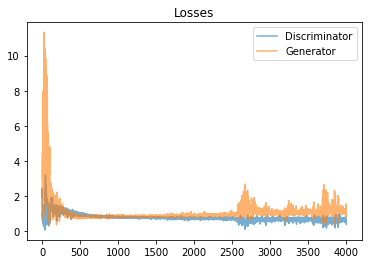

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

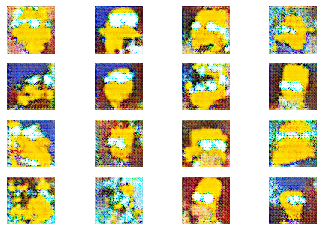

 52%|█████▏    | 26/50 [27:09<24:51, 62.14s/it]

Epoch: 27/50 | Step: 1/154 [D loss: 0.8238, acc.: 44.53%] [G loss: 0.9195]
Epoch: 27/50 | Step: 2/154 [D loss: 0.5501, acc.: 65.62%] [G loss: 1.1724]
Epoch: 27/50 | Step: 3/154 [D loss: 0.7976, acc.: 51.56%] [G loss: 1.1318]
Epoch: 27/50 | Step: 4/154 [D loss: 0.7159, acc.: 53.91%] [G loss: 1.0245]
Epoch: 27/50 | Step: 5/154 [D loss: 0.5127, acc.: 80.47%] [G loss: 0.9768]
Epoch: 27/50 | Step: 6/154 [D loss: 0.4243, acc.: 86.72%] [G loss: 0.8120]
Epoch: 27/50 | Step: 7/154 [D loss: 0.6925, acc.: 57.81%] [G loss: 0.9480]
Epoch: 27/50 | Step: 8/154 [D loss: 0.5680, acc.: 74.22%] [G loss: 1.1594]
Epoch: 27/50 | Step: 9/154 [D loss: 0.6282, acc.: 61.72%] [G loss: 1.3010]
Epoch: 27/50 | Step: 10/154 [D loss: 0.6558, acc.: 60.16%] [G loss: 1.1673]
Epoch: 27/50 | Step: 11/154 [D loss: 0.6065, acc.: 67.97%] [G loss: 1.2499]
Epoch: 27/50 | Step: 12/154 [D loss: 0.4501, acc.: 85.94%] [G loss: 1.5598]
Epoch: 27/50 | Step: 13/154 [D loss: 0.6759, acc.: 60.16%] [G loss: 1.0608]
Epoch: 27/50 | Step: 

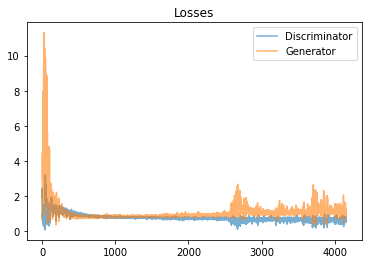

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

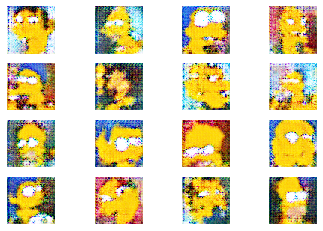

 54%|█████▍    | 27/50 [28:11<23:47, 62.07s/it]

Epoch: 28/50 | Step: 1/154 [D loss: 0.4468, acc.: 86.72%] [G loss: 0.8036]
Epoch: 28/50 | Step: 2/154 [D loss: 0.6166, acc.: 66.41%] [G loss: 0.8025]
Epoch: 28/50 | Step: 3/154 [D loss: 0.6733, acc.: 59.38%] [G loss: 0.9167]
Epoch: 28/50 | Step: 4/154 [D loss: 0.8041, acc.: 39.84%] [G loss: 1.2565]
Epoch: 28/50 | Step: 5/154 [D loss: 0.5772, acc.: 77.34%] [G loss: 1.5805]
Epoch: 28/50 | Step: 6/154 [D loss: 0.4990, acc.: 79.69%] [G loss: 1.4447]
Epoch: 28/50 | Step: 7/154 [D loss: 0.6662, acc.: 57.03%] [G loss: 1.6358]
Epoch: 28/50 | Step: 8/154 [D loss: 0.5424, acc.: 77.34%] [G loss: 1.2016]
Epoch: 28/50 | Step: 9/154 [D loss: 0.4737, acc.: 82.03%] [G loss: 1.4020]
Epoch: 28/50 | Step: 10/154 [D loss: 0.6690, acc.: 56.25%] [G loss: 1.4453]
Epoch: 28/50 | Step: 11/154 [D loss: 0.6629, acc.: 60.16%] [G loss: 1.1856]
Epoch: 28/50 | Step: 12/154 [D loss: 0.4295, acc.: 85.94%] [G loss: 1.2772]
Epoch: 28/50 | Step: 13/154 [D loss: 0.5986, acc.: 71.09%] [G loss: 1.5233]
Epoch: 28/50 | Step: 

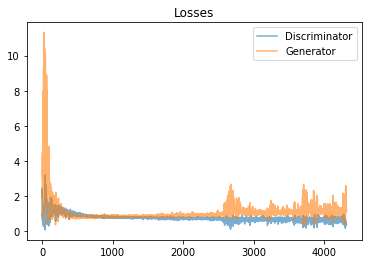

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

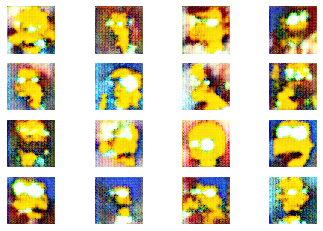

 56%|█████▌    | 28/50 [29:13<22:46, 62.13s/it]

Epoch: 29/50 | Step: 1/154 [D loss: 0.3895, acc.: 90.62%] [G loss: 0.9287]
Epoch: 29/50 | Step: 2/154 [D loss: 0.5600, acc.: 70.31%] [G loss: 1.6907]
Epoch: 29/50 | Step: 3/154 [D loss: 0.2842, acc.: 92.97%] [G loss: 1.4465]
Epoch: 29/50 | Step: 4/154 [D loss: 0.7108, acc.: 62.50%] [G loss: 0.9661]
Epoch: 29/50 | Step: 5/154 [D loss: 0.4966, acc.: 71.88%] [G loss: 1.7830]
Epoch: 29/50 | Step: 6/154 [D loss: 0.4583, acc.: 88.28%] [G loss: 2.4768]
Epoch: 29/50 | Step: 7/154 [D loss: 0.5479, acc.: 65.62%] [G loss: 1.4822]
Epoch: 29/50 | Step: 8/154 [D loss: 0.4127, acc.: 90.62%] [G loss: 0.9232]
Epoch: 29/50 | Step: 9/154 [D loss: 0.5443, acc.: 75.00%] [G loss: 1.2760]
Epoch: 29/50 | Step: 10/154 [D loss: 0.8712, acc.: 32.81%] [G loss: 0.9724]
Epoch: 29/50 | Step: 11/154 [D loss: 0.4703, acc.: 84.38%] [G loss: 1.3736]
Epoch: 29/50 | Step: 12/154 [D loss: 0.3923, acc.: 90.62%] [G loss: 1.5781]
Epoch: 29/50 | Step: 13/154 [D loss: 0.5397, acc.: 74.22%] [G loss: 1.3189]
Epoch: 29/50 | Step: 

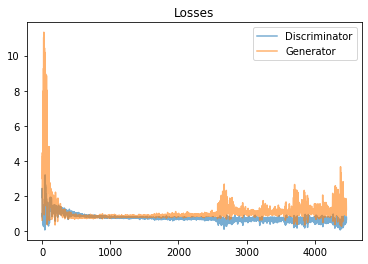

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

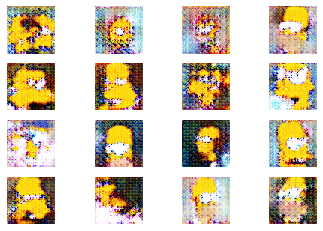

 58%|█████▊    | 29/50 [30:15<21:43, 62.09s/it]

Epoch: 30/50 | Step: 1/154 [D loss: 0.5662, acc.: 71.88%] [G loss: 1.3622]
Epoch: 30/50 | Step: 2/154 [D loss: 0.5558, acc.: 74.22%] [G loss: 1.6731]
Epoch: 30/50 | Step: 3/154 [D loss: 0.4926, acc.: 82.81%] [G loss: 1.3853]
Epoch: 30/50 | Step: 4/154 [D loss: 0.5787, acc.: 71.88%] [G loss: 1.2962]
Epoch: 30/50 | Step: 5/154 [D loss: 0.5675, acc.: 71.09%] [G loss: 1.3869]
Epoch: 30/50 | Step: 6/154 [D loss: 0.5010, acc.: 78.91%] [G loss: 1.0856]
Epoch: 30/50 | Step: 7/154 [D loss: 0.6655, acc.: 57.81%] [G loss: 1.2207]
Epoch: 30/50 | Step: 8/154 [D loss: 0.6726, acc.: 64.06%] [G loss: 1.2953]
Epoch: 30/50 | Step: 9/154 [D loss: 0.6654, acc.: 59.38%] [G loss: 1.2549]
Epoch: 30/50 | Step: 10/154 [D loss: 0.5503, acc.: 73.44%] [G loss: 1.0667]
Epoch: 30/50 | Step: 11/154 [D loss: 0.6449, acc.: 61.72%] [G loss: 1.1604]
Epoch: 30/50 | Step: 12/154 [D loss: 0.6344, acc.: 62.50%] [G loss: 1.3328]
Epoch: 30/50 | Step: 13/154 [D loss: 0.4802, acc.: 78.12%] [G loss: 1.3449]
Epoch: 30/50 | Step: 

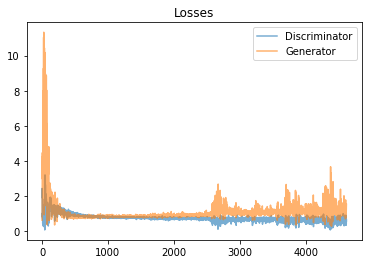

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

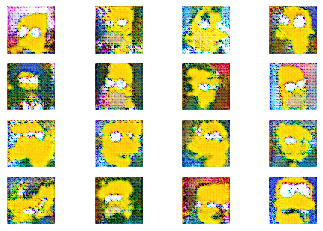

 60%|██████    | 30/50 [31:18<20:43, 62.18s/it]

Epoch: 31/50 | Step: 1/154 [D loss: 0.4017, acc.: 79.69%] [G loss: 1.5262]
Epoch: 31/50 | Step: 2/154 [D loss: 0.6235, acc.: 67.19%] [G loss: 1.2465]
Epoch: 31/50 | Step: 3/154 [D loss: 0.5414, acc.: 72.66%] [G loss: 1.3520]
Epoch: 31/50 | Step: 4/154 [D loss: 0.5671, acc.: 71.09%] [G loss: 1.3896]
Epoch: 31/50 | Step: 5/154 [D loss: 0.5516, acc.: 73.44%] [G loss: 1.4094]
Epoch: 31/50 | Step: 6/154 [D loss: 0.4880, acc.: 82.03%] [G loss: 1.3424]
Epoch: 31/50 | Step: 7/154 [D loss: 0.6255, acc.: 61.72%] [G loss: 1.3787]
Epoch: 31/50 | Step: 8/154 [D loss: 0.4882, acc.: 82.81%] [G loss: 1.0517]
Epoch: 31/50 | Step: 9/154 [D loss: 0.4451, acc.: 85.16%] [G loss: 0.8391]
Epoch: 31/50 | Step: 10/154 [D loss: 0.5744, acc.: 69.53%] [G loss: 1.1649]
Epoch: 31/50 | Step: 11/154 [D loss: 0.4991, acc.: 79.69%] [G loss: 1.2659]
Epoch: 31/50 | Step: 12/154 [D loss: 0.6431, acc.: 63.28%] [G loss: 1.5166]
Epoch: 31/50 | Step: 13/154 [D loss: 0.4493, acc.: 78.91%] [G loss: 1.6845]
Epoch: 31/50 | Step: 

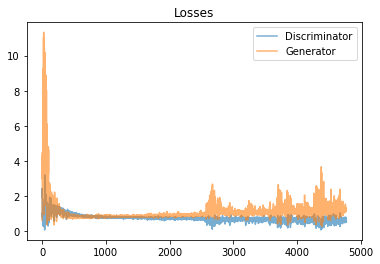

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

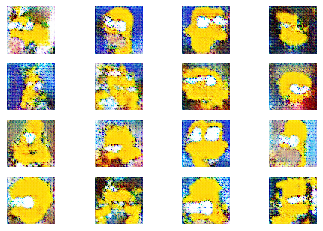

 62%|██████▏   | 31/50 [32:20<19:40, 62.15s/it]

Epoch: 32/50 | Step: 1/154 [D loss: 0.7898, acc.: 44.53%] [G loss: 1.1386]
Epoch: 32/50 | Step: 2/154 [D loss: 0.5717, acc.: 69.53%] [G loss: 1.2281]
Epoch: 32/50 | Step: 3/154 [D loss: 0.6119, acc.: 71.88%] [G loss: 1.1637]
Epoch: 32/50 | Step: 4/154 [D loss: 0.6733, acc.: 54.69%] [G loss: 1.1594]
Epoch: 32/50 | Step: 5/154 [D loss: 0.5812, acc.: 67.19%] [G loss: 1.2521]
Epoch: 32/50 | Step: 6/154 [D loss: 0.5544, acc.: 72.66%] [G loss: 1.2542]
Epoch: 32/50 | Step: 7/154 [D loss: 0.7997, acc.: 45.31%] [G loss: 1.1645]
Epoch: 32/50 | Step: 8/154 [D loss: 0.6496, acc.: 65.62%] [G loss: 1.1868]
Epoch: 32/50 | Step: 9/154 [D loss: 0.7146, acc.: 61.72%] [G loss: 1.2731]
Epoch: 32/50 | Step: 10/154 [D loss: 0.6061, acc.: 65.62%] [G loss: 1.3676]
Epoch: 32/50 | Step: 11/154 [D loss: 0.6309, acc.: 60.16%] [G loss: 1.3277]
Epoch: 32/50 | Step: 12/154 [D loss: 0.4922, acc.: 78.12%] [G loss: 1.1136]
Epoch: 32/50 | Step: 13/154 [D loss: 0.4840, acc.: 83.59%] [G loss: 0.9641]
Epoch: 32/50 | Step: 

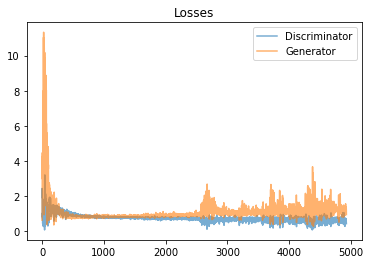

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

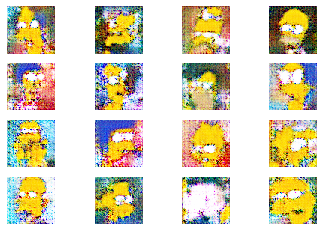

 64%|██████▍   | 32/50 [33:22<18:38, 62.14s/it]

Epoch: 33/50 | Step: 1/154 [D loss: 0.3163, acc.: 89.06%] [G loss: 0.5369]
Epoch: 33/50 | Step: 2/154 [D loss: 0.3848, acc.: 89.84%] [G loss: 0.6937]
Epoch: 33/50 | Step: 3/154 [D loss: 0.5858, acc.: 60.16%] [G loss: 1.2447]
Epoch: 33/50 | Step: 4/154 [D loss: 0.9462, acc.: 29.69%] [G loss: 1.1719]
Epoch: 33/50 | Step: 5/154 [D loss: 0.4997, acc.: 81.25%] [G loss: 1.4075]
Epoch: 33/50 | Step: 6/154 [D loss: 0.5791, acc.: 74.22%] [G loss: 1.5635]
Epoch: 33/50 | Step: 7/154 [D loss: 0.6289, acc.: 65.62%] [G loss: 1.2753]
Epoch: 33/50 | Step: 8/154 [D loss: 0.6235, acc.: 66.41%] [G loss: 1.1361]
Epoch: 33/50 | Step: 9/154 [D loss: 0.6250, acc.: 71.88%] [G loss: 1.3562]
Epoch: 33/50 | Step: 10/154 [D loss: 0.6504, acc.: 64.84%] [G loss: 1.2229]
Epoch: 33/50 | Step: 11/154 [D loss: 0.5537, acc.: 73.44%] [G loss: 1.2188]
Epoch: 33/50 | Step: 12/154 [D loss: 0.5171, acc.: 78.12%] [G loss: 1.0370]
Epoch: 33/50 | Step: 13/154 [D loss: 0.5823, acc.: 72.66%] [G loss: 1.1632]
Epoch: 33/50 | Step: 

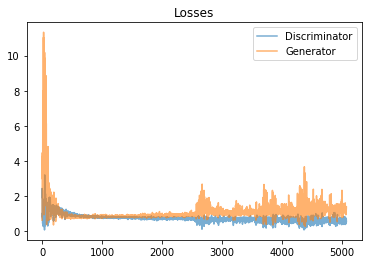

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

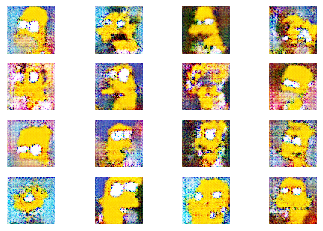

 66%|██████▌   | 33/50 [34:24<17:35, 62.07s/it]

Epoch: 34/50 | Step: 1/154 [D loss: 0.6849, acc.: 56.25%] [G loss: 1.1875]
Epoch: 34/50 | Step: 2/154 [D loss: 0.5131, acc.: 78.12%] [G loss: 1.2527]
Epoch: 34/50 | Step: 3/154 [D loss: 0.5233, acc.: 82.03%] [G loss: 1.3138]
Epoch: 34/50 | Step: 4/154 [D loss: 0.5754, acc.: 74.22%] [G loss: 1.2699]
Epoch: 34/50 | Step: 5/154 [D loss: 0.5182, acc.: 80.47%] [G loss: 1.3157]
Epoch: 34/50 | Step: 6/154 [D loss: 0.4490, acc.: 86.72%] [G loss: 1.3563]
Epoch: 34/50 | Step: 7/154 [D loss: 0.4869, acc.: 78.12%] [G loss: 1.0188]
Epoch: 34/50 | Step: 8/154 [D loss: 0.4200, acc.: 86.72%] [G loss: 0.8141]
Epoch: 34/50 | Step: 9/154 [D loss: 0.5260, acc.: 77.34%] [G loss: 1.0392]
Epoch: 34/50 | Step: 10/154 [D loss: 0.7210, acc.: 54.69%] [G loss: 1.1995]
Epoch: 34/50 | Step: 11/154 [D loss: 0.6803, acc.: 61.72%] [G loss: 1.2870]
Epoch: 34/50 | Step: 12/154 [D loss: 0.6109, acc.: 67.19%] [G loss: 1.4004]
Epoch: 34/50 | Step: 13/154 [D loss: 0.4828, acc.: 80.47%] [G loss: 1.4731]
Epoch: 34/50 | Step: 

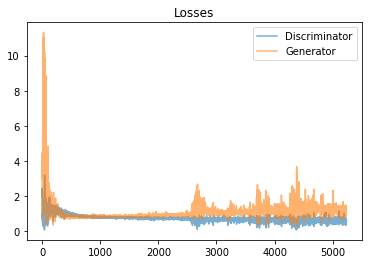

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

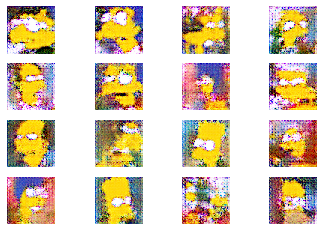

 68%|██████▊   | 34/50 [35:26<16:32, 62.03s/it]

Epoch: 35/50 | Step: 1/154 [D loss: 0.5479, acc.: 75.78%] [G loss: 1.2912]
Epoch: 35/50 | Step: 2/154 [D loss: 0.6601, acc.: 59.38%] [G loss: 1.2800]
Epoch: 35/50 | Step: 3/154 [D loss: 0.7994, acc.: 43.75%] [G loss: 0.9789]
Epoch: 35/50 | Step: 4/154 [D loss: 0.6597, acc.: 60.16%] [G loss: 1.1738]
Epoch: 35/50 | Step: 5/154 [D loss: 0.5322, acc.: 72.66%] [G loss: 1.2197]
Epoch: 35/50 | Step: 6/154 [D loss: 0.5780, acc.: 72.66%] [G loss: 1.2852]
Epoch: 35/50 | Step: 7/154 [D loss: 0.6181, acc.: 63.28%] [G loss: 1.3100]
Epoch: 35/50 | Step: 8/154 [D loss: 0.6441, acc.: 60.16%] [G loss: 1.0337]
Epoch: 35/50 | Step: 9/154 [D loss: 0.5764, acc.: 70.31%] [G loss: 1.1146]
Epoch: 35/50 | Step: 10/154 [D loss: 0.6446, acc.: 67.19%] [G loss: 1.2068]
Epoch: 35/50 | Step: 11/154 [D loss: 0.7023, acc.: 53.91%] [G loss: 1.1071]
Epoch: 35/50 | Step: 12/154 [D loss: 0.5762, acc.: 70.31%] [G loss: 1.0795]
Epoch: 35/50 | Step: 13/154 [D loss: 0.5792, acc.: 67.19%] [G loss: 1.2213]
Epoch: 35/50 | Step: 

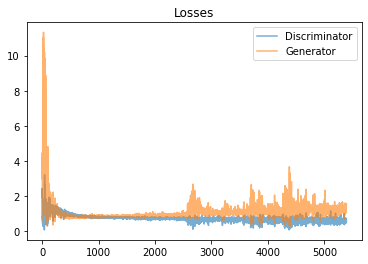

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

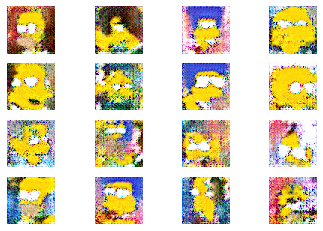

 70%|███████   | 35/50 [36:28<15:29, 61.97s/it]

Epoch: 36/50 | Step: 1/154 [D loss: 0.4781, acc.: 79.69%] [G loss: 1.3219]
Epoch: 36/50 | Step: 2/154 [D loss: 0.4176, acc.: 84.38%] [G loss: 1.2636]
Epoch: 36/50 | Step: 3/154 [D loss: 0.4031, acc.: 89.84%] [G loss: 1.1373]
Epoch: 36/50 | Step: 4/154 [D loss: 0.5510, acc.: 75.00%] [G loss: 1.3855]
Epoch: 36/50 | Step: 5/154 [D loss: 0.6312, acc.: 65.62%] [G loss: 1.2894]
Epoch: 36/50 | Step: 6/154 [D loss: 0.5847, acc.: 69.53%] [G loss: 1.5213]
Epoch: 36/50 | Step: 7/154 [D loss: 0.4906, acc.: 77.34%] [G loss: 1.0552]
Epoch: 36/50 | Step: 8/154 [D loss: 0.7921, acc.: 43.75%] [G loss: 0.8966]
Epoch: 36/50 | Step: 9/154 [D loss: 0.6650, acc.: 57.81%] [G loss: 0.9364]
Epoch: 36/50 | Step: 10/154 [D loss: 0.5177, acc.: 78.12%] [G loss: 1.0599]
Epoch: 36/50 | Step: 11/154 [D loss: 0.6193, acc.: 62.50%] [G loss: 1.3485]
Epoch: 36/50 | Step: 12/154 [D loss: 0.5527, acc.: 70.31%] [G loss: 1.1076]
Epoch: 36/50 | Step: 13/154 [D loss: 0.4739, acc.: 79.69%] [G loss: 1.1587]
Epoch: 36/50 | Step: 

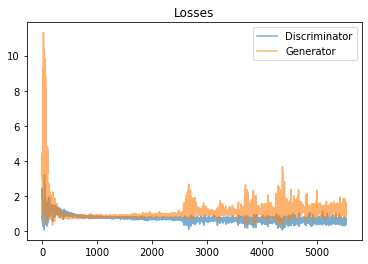

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

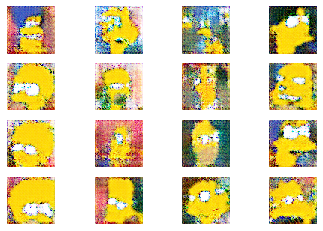

 72%|███████▏  | 36/50 [37:30<14:28, 62.02s/it]

Epoch: 37/50 | Step: 1/154 [D loss: 0.5699, acc.: 67.97%] [G loss: 1.3257]
Epoch: 37/50 | Step: 2/154 [D loss: 0.6906, acc.: 56.25%] [G loss: 1.2518]
Epoch: 37/50 | Step: 3/154 [D loss: 0.4748, acc.: 84.38%] [G loss: 1.3320]
Epoch: 37/50 | Step: 4/154 [D loss: 0.5908, acc.: 67.19%] [G loss: 1.2985]
Epoch: 37/50 | Step: 5/154 [D loss: 0.4955, acc.: 79.69%] [G loss: 1.4665]
Epoch: 37/50 | Step: 6/154 [D loss: 0.6001, acc.: 67.19%] [G loss: 1.4611]
Epoch: 37/50 | Step: 7/154 [D loss: 0.3987, acc.: 87.50%] [G loss: 1.4496]
Epoch: 37/50 | Step: 8/154 [D loss: 0.5052, acc.: 75.78%] [G loss: 1.4606]
Epoch: 37/50 | Step: 9/154 [D loss: 0.9053, acc.: 33.59%] [G loss: 1.1444]
Epoch: 37/50 | Step: 10/154 [D loss: 0.3919, acc.: 92.97%] [G loss: 1.5170]
Epoch: 37/50 | Step: 11/154 [D loss: 0.3268, acc.: 85.94%] [G loss: 1.0454]
Epoch: 37/50 | Step: 12/154 [D loss: 0.6801, acc.: 59.38%] [G loss: 1.1475]
Epoch: 37/50 | Step: 13/154 [D loss: 0.5733, acc.: 71.09%] [G loss: 1.4940]
Epoch: 37/50 | Step: 

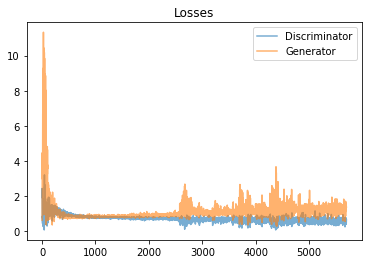

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

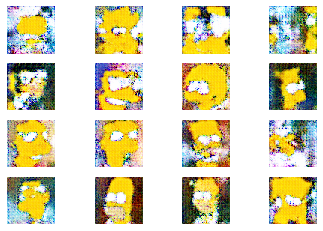

 74%|███████▍  | 37/50 [38:32<13:25, 62.00s/it]

Epoch: 38/50 | Step: 1/154 [D loss: 0.2809, acc.: 92.97%] [G loss: 1.4362]
Epoch: 38/50 | Step: 2/154 [D loss: 0.5687, acc.: 75.00%] [G loss: 1.2178]
Epoch: 38/50 | Step: 3/154 [D loss: 0.6702, acc.: 57.81%] [G loss: 1.3469]
Epoch: 38/50 | Step: 4/154 [D loss: 0.4626, acc.: 85.94%] [G loss: 1.6044]
Epoch: 38/50 | Step: 5/154 [D loss: 0.5350, acc.: 71.09%] [G loss: 1.3633]
Epoch: 38/50 | Step: 6/154 [D loss: 0.4587, acc.: 82.03%] [G loss: 1.4893]
Epoch: 38/50 | Step: 7/154 [D loss: 0.3912, acc.: 89.84%] [G loss: 1.3759]
Epoch: 38/50 | Step: 8/154 [D loss: 0.4139, acc.: 84.38%] [G loss: 1.0433]
Epoch: 38/50 | Step: 9/154 [D loss: 0.4379, acc.: 86.72%] [G loss: 1.4535]
Epoch: 38/50 | Step: 10/154 [D loss: 0.5571, acc.: 71.09%] [G loss: 1.3646]
Epoch: 38/50 | Step: 11/154 [D loss: 0.4523, acc.: 88.28%] [G loss: 1.1338]
Epoch: 38/50 | Step: 12/154 [D loss: 0.4503, acc.: 83.59%] [G loss: 1.3156]
Epoch: 38/50 | Step: 13/154 [D loss: 0.3399, acc.: 93.75%] [G loss: 1.1197]
Epoch: 38/50 | Step: 

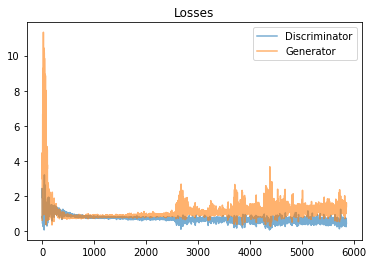

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

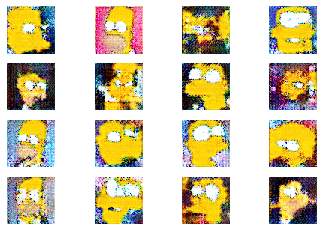

 76%|███████▌  | 38/50 [39:34<12:23, 61.99s/it]

Epoch: 39/50 | Step: 1/154 [D loss: 0.4997, acc.: 78.12%] [G loss: 1.4882]
Epoch: 39/50 | Step: 2/154 [D loss: 0.4265, acc.: 89.06%] [G loss: 1.4385]
Epoch: 39/50 | Step: 3/154 [D loss: 0.5822, acc.: 70.31%] [G loss: 1.4002]
Epoch: 39/50 | Step: 4/154 [D loss: 0.4866, acc.: 85.16%] [G loss: 1.5787]
Epoch: 39/50 | Step: 5/154 [D loss: 0.8113, acc.: 42.19%] [G loss: 1.4168]
Epoch: 39/50 | Step: 6/154 [D loss: 0.8367, acc.: 44.53%] [G loss: 1.1527]
Epoch: 39/50 | Step: 7/154 [D loss: 0.5784, acc.: 67.97%] [G loss: 1.4905]
Epoch: 39/50 | Step: 8/154 [D loss: 0.5041, acc.: 76.56%] [G loss: 1.6975]
Epoch: 39/50 | Step: 9/154 [D loss: 0.6216, acc.: 62.50%] [G loss: 1.5206]
Epoch: 39/50 | Step: 10/154 [D loss: 0.5985, acc.: 66.41%] [G loss: 1.5739]
Epoch: 39/50 | Step: 11/154 [D loss: 0.5854, acc.: 69.53%] [G loss: 1.6356]
Epoch: 39/50 | Step: 12/154 [D loss: 0.3442, acc.: 82.03%] [G loss: 1.2661]
Epoch: 39/50 | Step: 13/154 [D loss: 0.4123, acc.: 83.59%] [G loss: 1.1949]
Epoch: 39/50 | Step: 

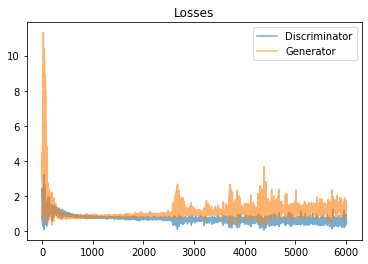

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

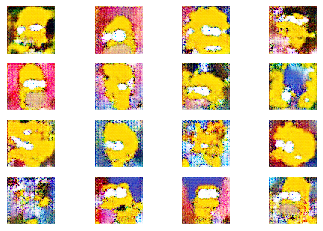

 78%|███████▊  | 39/50 [40:36<11:21, 61.95s/it]

Epoch: 40/50 | Step: 1/154 [D loss: 0.5437, acc.: 73.44%] [G loss: 1.3438]
Epoch: 40/50 | Step: 2/154 [D loss: 0.4421, acc.: 85.16%] [G loss: 1.3064]
Epoch: 40/50 | Step: 3/154 [D loss: 0.5089, acc.: 77.34%] [G loss: 1.1022]
Epoch: 40/50 | Step: 4/154 [D loss: 0.4089, acc.: 87.50%] [G loss: 1.0453]
Epoch: 40/50 | Step: 5/154 [D loss: 0.4004, acc.: 84.38%] [G loss: 0.6987]
Epoch: 40/50 | Step: 6/154 [D loss: 0.2991, acc.: 96.09%] [G loss: 0.6810]
Epoch: 40/50 | Step: 7/154 [D loss: 0.4536, acc.: 80.47%] [G loss: 0.9772]
Epoch: 40/50 | Step: 8/154 [D loss: 0.4949, acc.: 75.00%] [G loss: 1.1826]
Epoch: 40/50 | Step: 9/154 [D loss: 0.6434, acc.: 67.19%] [G loss: 1.2824]
Epoch: 40/50 | Step: 10/154 [D loss: 0.6600, acc.: 64.84%] [G loss: 1.5016]
Epoch: 40/50 | Step: 11/154 [D loss: 0.3648, acc.: 92.97%] [G loss: 1.5973]
Epoch: 40/50 | Step: 12/154 [D loss: 0.2746, acc.: 91.41%] [G loss: 1.4107]
Epoch: 40/50 | Step: 13/154 [D loss: 0.4817, acc.: 82.03%] [G loss: 1.1284]
Epoch: 40/50 | Step: 

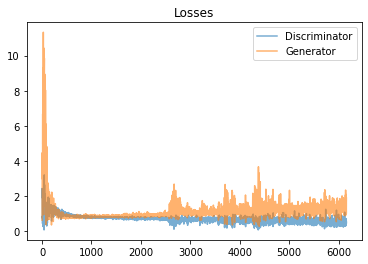

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

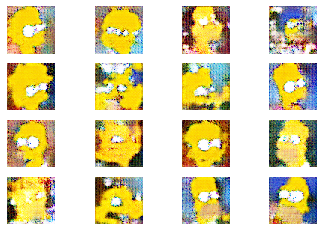

 80%|████████  | 40/50 [41:38<10:21, 62.18s/it]

Epoch: 41/50 | Step: 1/154 [D loss: 0.5982, acc.: 67.19%] [G loss: 1.5192]
Epoch: 41/50 | Step: 2/154 [D loss: 0.5498, acc.: 71.09%] [G loss: 1.5335]
Epoch: 41/50 | Step: 3/154 [D loss: 0.4659, acc.: 81.25%] [G loss: 1.5334]
Epoch: 41/50 | Step: 4/154 [D loss: 0.5604, acc.: 72.66%] [G loss: 1.3675]
Epoch: 41/50 | Step: 5/154 [D loss: 0.4402, acc.: 83.59%] [G loss: 1.3616]
Epoch: 41/50 | Step: 6/154 [D loss: 0.4014, acc.: 84.38%] [G loss: 1.0222]
Epoch: 41/50 | Step: 7/154 [D loss: 0.8540, acc.: 50.00%] [G loss: 1.1084]
Epoch: 41/50 | Step: 8/154 [D loss: 0.3738, acc.: 91.41%] [G loss: 1.2505]
Epoch: 41/50 | Step: 9/154 [D loss: 0.4502, acc.: 81.25%] [G loss: 1.1170]
Epoch: 41/50 | Step: 10/154 [D loss: 0.4660, acc.: 82.81%] [G loss: 1.3115]
Epoch: 41/50 | Step: 11/154 [D loss: 0.3833, acc.: 89.84%] [G loss: 1.4706]
Epoch: 41/50 | Step: 12/154 [D loss: 0.5211, acc.: 78.91%] [G loss: 1.4561]
Epoch: 41/50 | Step: 13/154 [D loss: 0.6453, acc.: 65.62%] [G loss: 1.5837]
Epoch: 41/50 | Step: 

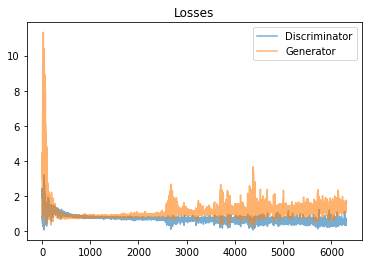

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

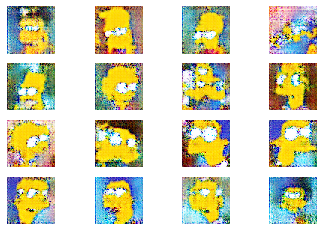

 82%|████████▏ | 41/50 [42:40<09:19, 62.11s/it]

Epoch: 42/50 | Step: 1/154 [D loss: 0.4657, acc.: 78.91%] [G loss: 1.3501]
Epoch: 42/50 | Step: 2/154 [D loss: 0.4424, acc.: 82.03%] [G loss: 1.5443]
Epoch: 42/50 | Step: 3/154 [D loss: 0.6269, acc.: 63.28%] [G loss: 1.2815]
Epoch: 42/50 | Step: 4/154 [D loss: 0.4543, acc.: 82.03%] [G loss: 1.5941]
Epoch: 42/50 | Step: 5/154 [D loss: 0.5397, acc.: 68.75%] [G loss: 1.3561]
Epoch: 42/50 | Step: 6/154 [D loss: 0.3890, acc.: 86.72%] [G loss: 0.9752]
Epoch: 42/50 | Step: 7/154 [D loss: 0.3646, acc.: 91.41%] [G loss: 1.2852]
Epoch: 42/50 | Step: 8/154 [D loss: 0.5754, acc.: 67.97%] [G loss: 1.5427]
Epoch: 42/50 | Step: 9/154 [D loss: 0.2655, acc.: 95.31%] [G loss: 1.4996]
Epoch: 42/50 | Step: 10/154 [D loss: 0.5245, acc.: 78.91%] [G loss: 1.1182]
Epoch: 42/50 | Step: 11/154 [D loss: 0.3363, acc.: 89.84%] [G loss: 0.9414]
Epoch: 42/50 | Step: 12/154 [D loss: 0.3684, acc.: 85.94%] [G loss: 0.6173]
Epoch: 42/50 | Step: 13/154 [D loss: 0.4480, acc.: 84.38%] [G loss: 0.7381]
Epoch: 42/50 | Step: 

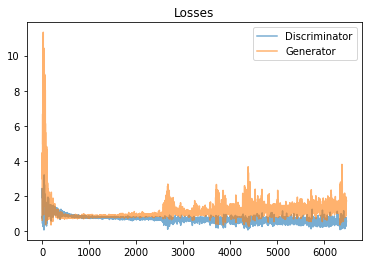

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

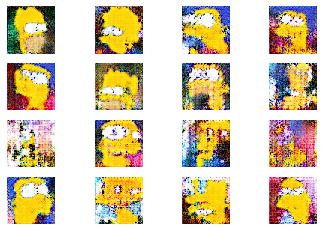

 84%|████████▍ | 42/50 [43:42<08:16, 62.06s/it]

Epoch: 43/50 | Step: 1/154 [D loss: 0.3905, acc.: 89.06%] [G loss: 1.5770]
Epoch: 43/50 | Step: 2/154 [D loss: 0.5745, acc.: 71.09%] [G loss: 1.2806]
Epoch: 43/50 | Step: 3/154 [D loss: 0.5337, acc.: 73.44%] [G loss: 1.5683]
Epoch: 43/50 | Step: 4/154 [D loss: 0.5233, acc.: 77.34%] [G loss: 1.4047]
Epoch: 43/50 | Step: 5/154 [D loss: 0.4475, acc.: 84.38%] [G loss: 1.6008]
Epoch: 43/50 | Step: 6/154 [D loss: 0.5221, acc.: 75.00%] [G loss: 1.6628]
Epoch: 43/50 | Step: 7/154 [D loss: 0.5158, acc.: 75.78%] [G loss: 1.6319]
Epoch: 43/50 | Step: 8/154 [D loss: 0.5407, acc.: 70.31%] [G loss: 1.5136]
Epoch: 43/50 | Step: 9/154 [D loss: 0.6672, acc.: 56.25%] [G loss: 1.3544]
Epoch: 43/50 | Step: 10/154 [D loss: 0.3904, acc.: 85.94%] [G loss: 1.6574]
Epoch: 43/50 | Step: 11/154 [D loss: 0.4401, acc.: 83.59%] [G loss: 1.5258]
Epoch: 43/50 | Step: 12/154 [D loss: 0.5681, acc.: 64.84%] [G loss: 1.0319]
Epoch: 43/50 | Step: 13/154 [D loss: 0.3979, acc.: 87.50%] [G loss: 1.1232]
Epoch: 43/50 | Step: 

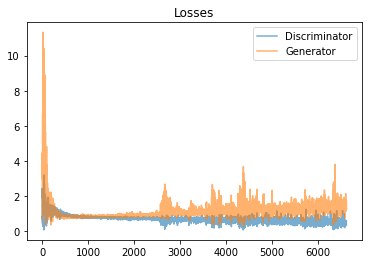

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

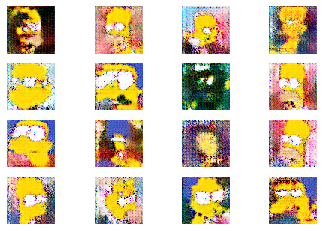

 86%|████████▌ | 43/50 [44:44<07:14, 62.01s/it]

Epoch: 44/50 | Step: 1/154 [D loss: 0.4285, acc.: 84.38%] [G loss: 1.7174]
Epoch: 44/50 | Step: 2/154 [D loss: 0.4443, acc.: 82.81%] [G loss: 1.7323]
Epoch: 44/50 | Step: 3/154 [D loss: 0.4670, acc.: 80.47%] [G loss: 1.7234]
Epoch: 44/50 | Step: 4/154 [D loss: 0.3373, acc.: 92.97%] [G loss: 1.1820]
Epoch: 44/50 | Step: 5/154 [D loss: 0.2488, acc.: 93.75%] [G loss: 0.8620]
Epoch: 44/50 | Step: 6/154 [D loss: 0.5945, acc.: 67.97%] [G loss: 1.5243]
Epoch: 44/50 | Step: 7/154 [D loss: 0.4372, acc.: 86.72%] [G loss: 1.9508]
Epoch: 44/50 | Step: 8/154 [D loss: 0.5669, acc.: 68.75%] [G loss: 1.7703]
Epoch: 44/50 | Step: 9/154 [D loss: 0.4729, acc.: 81.25%] [G loss: 1.4261]
Epoch: 44/50 | Step: 10/154 [D loss: 0.6530, acc.: 61.72%] [G loss: 1.0913]
Epoch: 44/50 | Step: 11/154 [D loss: 0.5576, acc.: 72.66%] [G loss: 1.4944]
Epoch: 44/50 | Step: 12/154 [D loss: 0.4841, acc.: 79.69%] [G loss: 1.7867]
Epoch: 44/50 | Step: 13/154 [D loss: 0.4973, acc.: 81.25%] [G loss: 1.7739]
Epoch: 44/50 | Step: 

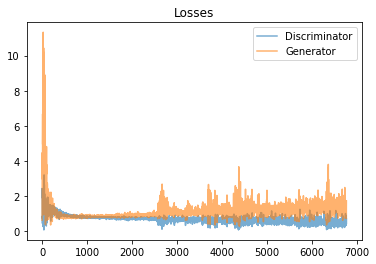

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

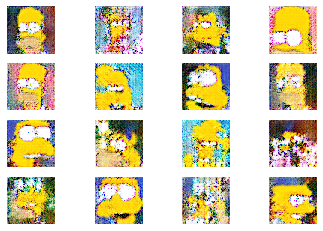

 88%|████████▊ | 44/50 [45:46<06:12, 62.08s/it]

Epoch: 45/50 | Step: 1/154 [D loss: 0.5215, acc.: 78.91%] [G loss: 1.7196]
Epoch: 45/50 | Step: 2/154 [D loss: 0.6104, acc.: 65.62%] [G loss: 1.3729]
Epoch: 45/50 | Step: 3/154 [D loss: 0.4695, acc.: 82.81%] [G loss: 1.5209]
Epoch: 45/50 | Step: 4/154 [D loss: 0.4432, acc.: 83.59%] [G loss: 1.5760]
Epoch: 45/50 | Step: 5/154 [D loss: 0.6011, acc.: 68.75%] [G loss: 1.4294]
Epoch: 45/50 | Step: 6/154 [D loss: 0.2541, acc.: 95.31%] [G loss: 1.2795]
Epoch: 45/50 | Step: 7/154 [D loss: 0.4907, acc.: 81.25%] [G loss: 1.6147]
Epoch: 45/50 | Step: 8/154 [D loss: 0.3002, acc.: 93.75%] [G loss: 1.1735]
Epoch: 45/50 | Step: 9/154 [D loss: 0.4869, acc.: 80.47%] [G loss: 1.4378]
Epoch: 45/50 | Step: 10/154 [D loss: 0.8384, acc.: 46.09%] [G loss: 1.7269]
Epoch: 45/50 | Step: 11/154 [D loss: 0.4103, acc.: 84.38%] [G loss: 1.6136]
Epoch: 45/50 | Step: 12/154 [D loss: 0.3819, acc.: 88.28%] [G loss: 1.4362]
Epoch: 45/50 | Step: 13/154 [D loss: 0.4135, acc.: 85.94%] [G loss: 1.8582]
Epoch: 45/50 | Step: 

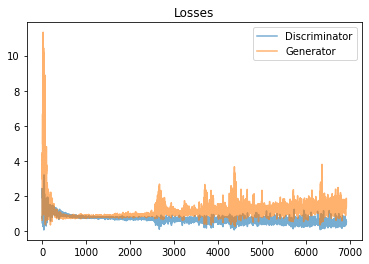

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

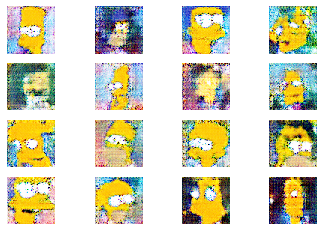

 90%|█████████ | 45/50 [46:48<05:10, 62.07s/it]

Epoch: 46/50 | Step: 1/154 [D loss: 0.5447, acc.: 75.00%] [G loss: 1.0844]
Epoch: 46/50 | Step: 2/154 [D loss: 0.4208, acc.: 85.16%] [G loss: 1.1253]
Epoch: 46/50 | Step: 3/154 [D loss: 0.4199, acc.: 85.16%] [G loss: 1.3252]
Epoch: 46/50 | Step: 4/154 [D loss: 0.5853, acc.: 70.31%] [G loss: 1.4366]
Epoch: 46/50 | Step: 5/154 [D loss: 0.4988, acc.: 75.00%] [G loss: 1.6254]
Epoch: 46/50 | Step: 6/154 [D loss: 0.4012, acc.: 84.38%] [G loss: 1.7903]
Epoch: 46/50 | Step: 7/154 [D loss: 0.4703, acc.: 82.03%] [G loss: 1.4307]
Epoch: 46/50 | Step: 8/154 [D loss: 0.5770, acc.: 73.44%] [G loss: 1.5220]
Epoch: 46/50 | Step: 9/154 [D loss: 0.3776, acc.: 85.16%] [G loss: 1.4458]
Epoch: 46/50 | Step: 10/154 [D loss: 0.6084, acc.: 65.62%] [G loss: 1.3895]
Epoch: 46/50 | Step: 11/154 [D loss: 0.4328, acc.: 82.81%] [G loss: 1.8199]
Epoch: 46/50 | Step: 12/154 [D loss: 0.4972, acc.: 76.56%] [G loss: 1.5270]
Epoch: 46/50 | Step: 13/154 [D loss: 0.5595, acc.: 75.00%] [G loss: 1.4896]
Epoch: 46/50 | Step: 

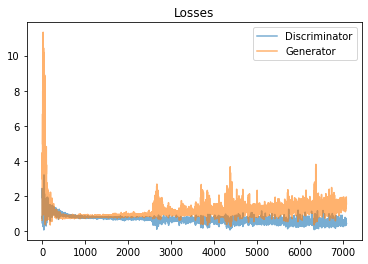

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

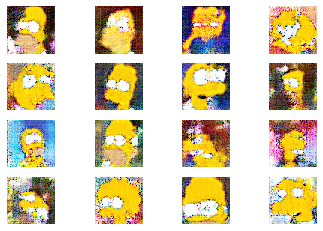

 92%|█████████▏| 46/50 [47:50<04:08, 62.05s/it]

Epoch: 47/50 | Step: 1/154 [D loss: 0.5607, acc.: 71.88%] [G loss: 1.6907]
Epoch: 47/50 | Step: 2/154 [D loss: 0.3874, acc.: 88.28%] [G loss: 2.1650]
Epoch: 47/50 | Step: 3/154 [D loss: 0.6713, acc.: 64.84%] [G loss: 1.4003]
Epoch: 47/50 | Step: 4/154 [D loss: 0.3656, acc.: 92.19%] [G loss: 1.6762]
Epoch: 47/50 | Step: 5/154 [D loss: 0.4707, acc.: 83.59%] [G loss: 1.6223]
Epoch: 47/50 | Step: 6/154 [D loss: 0.5635, acc.: 70.31%] [G loss: 1.4864]
Epoch: 47/50 | Step: 7/154 [D loss: 0.3956, acc.: 87.50%] [G loss: 1.6253]
Epoch: 47/50 | Step: 8/154 [D loss: 0.3603, acc.: 90.62%] [G loss: 1.4800]
Epoch: 47/50 | Step: 9/154 [D loss: 0.5546, acc.: 69.53%] [G loss: 1.4177]
Epoch: 47/50 | Step: 10/154 [D loss: 0.4045, acc.: 86.72%] [G loss: 1.7923]
Epoch: 47/50 | Step: 11/154 [D loss: 0.5038, acc.: 76.56%] [G loss: 1.7471]
Epoch: 47/50 | Step: 12/154 [D loss: 0.3502, acc.: 88.28%] [G loss: 1.3140]
Epoch: 47/50 | Step: 13/154 [D loss: 0.4807, acc.: 80.47%] [G loss: 1.4821]
Epoch: 47/50 | Step: 

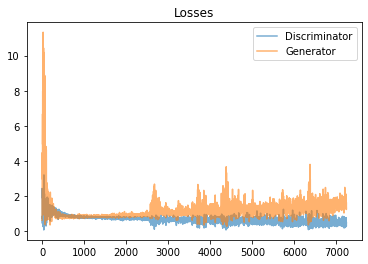

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

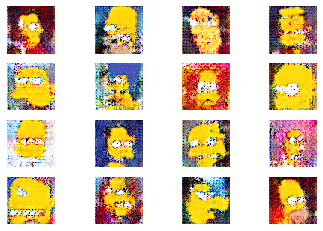

 94%|█████████▍| 47/50 [48:52<03:06, 62.03s/it]

Epoch: 48/50 | Step: 1/154 [D loss: 0.3617, acc.: 89.84%] [G loss: 1.1870]
Epoch: 48/50 | Step: 2/154 [D loss: 0.5979, acc.: 65.62%] [G loss: 1.9428]
Epoch: 48/50 | Step: 3/154 [D loss: 0.3082, acc.: 90.62%] [G loss: 2.2991]
Epoch: 48/50 | Step: 4/154 [D loss: 0.5388, acc.: 75.78%] [G loss: 1.6738]
Epoch: 48/50 | Step: 5/154 [D loss: 0.5278, acc.: 74.22%] [G loss: 1.5403]
Epoch: 48/50 | Step: 6/154 [D loss: 0.4187, acc.: 86.72%] [G loss: 1.4764]
Epoch: 48/50 | Step: 7/154 [D loss: 0.2549, acc.: 93.75%] [G loss: 1.3369]
Epoch: 48/50 | Step: 8/154 [D loss: 0.2684, acc.: 98.44%] [G loss: 1.2998]
Epoch: 48/50 | Step: 9/154 [D loss: 0.4357, acc.: 84.38%] [G loss: 1.0255]
Epoch: 48/50 | Step: 10/154 [D loss: 0.2423, acc.: 96.88%] [G loss: 1.0908]
Epoch: 48/50 | Step: 11/154 [D loss: 0.3108, acc.: 95.31%] [G loss: 1.0723]
Epoch: 48/50 | Step: 12/154 [D loss: 0.4607, acc.: 82.81%] [G loss: 1.0668]
Epoch: 48/50 | Step: 13/154 [D loss: 0.3713, acc.: 91.41%] [G loss: 1.5825]
Epoch: 48/50 | Step: 

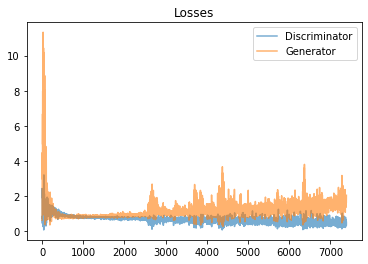

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

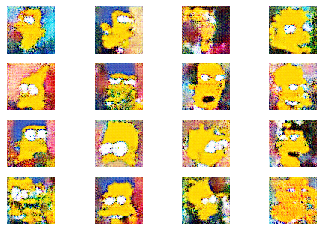

 96%|█████████▌| 48/50 [49:54<02:03, 62.00s/it]

Epoch: 49/50 | Step: 1/154 [D loss: 0.4885, acc.: 77.34%] [G loss: 1.8278]
Epoch: 49/50 | Step: 2/154 [D loss: 0.6246, acc.: 62.50%] [G loss: 1.7023]
Epoch: 49/50 | Step: 3/154 [D loss: 0.4148, acc.: 83.59%] [G loss: 2.1985]
Epoch: 49/50 | Step: 4/154 [D loss: 0.6245, acc.: 64.84%] [G loss: 2.0929]
Epoch: 49/50 | Step: 5/154 [D loss: 0.4142, acc.: 81.25%] [G loss: 1.8444]
Epoch: 49/50 | Step: 6/154 [D loss: 0.7394, acc.: 57.03%] [G loss: 1.5626]
Epoch: 49/50 | Step: 7/154 [D loss: 0.3002, acc.: 92.97%] [G loss: 2.0155]
Epoch: 49/50 | Step: 8/154 [D loss: 0.4291, acc.: 85.16%] [G loss: 1.9048]
Epoch: 49/50 | Step: 9/154 [D loss: 0.3375, acc.: 92.19%] [G loss: 1.9026]
Epoch: 49/50 | Step: 10/154 [D loss: 0.4394, acc.: 80.47%] [G loss: 1.8126]
Epoch: 49/50 | Step: 11/154 [D loss: 0.5512, acc.: 73.44%] [G loss: 1.6632]
Epoch: 49/50 | Step: 12/154 [D loss: 0.4001, acc.: 85.94%] [G loss: 1.8741]
Epoch: 49/50 | Step: 13/154 [D loss: 0.3625, acc.: 87.50%] [G loss: 1.6095]
Epoch: 49/50 | Step: 

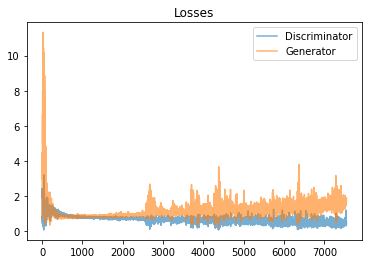

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

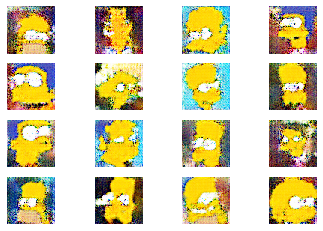

 98%|█████████▊| 49/50 [50:57<01:02, 62.09s/it]

Epoch: 50/50 | Step: 1/154 [D loss: 0.4254, acc.: 82.03%] [G loss: 1.7426]
Epoch: 50/50 | Step: 2/154 [D loss: 0.2999, acc.: 92.19%] [G loss: 2.0424]
Epoch: 50/50 | Step: 3/154 [D loss: 0.5454, acc.: 69.53%] [G loss: 1.7154]
Epoch: 50/50 | Step: 4/154 [D loss: 0.4106, acc.: 84.38%] [G loss: 1.8924]
Epoch: 50/50 | Step: 5/154 [D loss: 0.3406, acc.: 92.19%] [G loss: 1.6097]
Epoch: 50/50 | Step: 6/154 [D loss: 0.4531, acc.: 79.69%] [G loss: 1.2454]
Epoch: 50/50 | Step: 7/154 [D loss: 0.4063, acc.: 85.16%] [G loss: 1.8420]
Epoch: 50/50 | Step: 8/154 [D loss: 0.3457, acc.: 89.84%] [G loss: 1.6670]
Epoch: 50/50 | Step: 9/154 [D loss: 0.3997, acc.: 89.06%] [G loss: 1.6754]
Epoch: 50/50 | Step: 10/154 [D loss: 0.5218, acc.: 77.34%] [G loss: 1.8070]
Epoch: 50/50 | Step: 11/154 [D loss: 0.3088, acc.: 94.53%] [G loss: 1.7795]
Epoch: 50/50 | Step: 12/154 [D loss: 0.3730, acc.: 89.06%] [G loss: 2.1591]
Epoch: 50/50 | Step: 13/154 [D loss: 0.3989, acc.: 85.94%] [G loss: 1.6056]
Epoch: 50/50 | Step: 

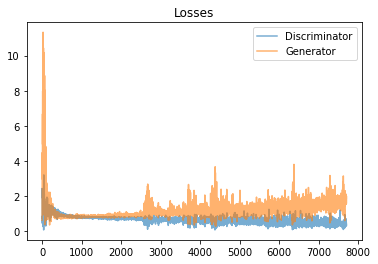

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

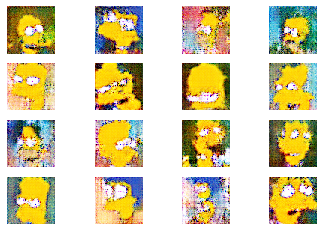

100%|██████████| 50/50 [51:59<00:00, 62.18s/it]


In [32]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
EPOCHS =50
d_loss_list = []
g_loss_list = []

for epoch in tqdm(range(EPOCHS)):
    epoch += 1 #start from 1
    # So, need to append d_loss, g_loss, and step to a dataframe with epoch as 
    
    for step in range(steps_per_epoch):
        step += 1 #start from 1

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half of images
        idx = np.random.randint(0, images.shape[0], BATCH_SIZE)
        imgs = images[idx]

        # Sample noise and generate a batch of new images
        noise = np.random.normal(0, 1, (BATCH_SIZE, NOISE_SIZE))
        gen_imgs = model_generator.predict(noise)


        # Train the discriminator (real classified as ones and generated as zeros)
        d_loss_real = model_discriminator.train_on_batch(imgs, valid)
        d_loss_fake = model_discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train GAN
        # ---------------------

        # Train the generator (wants discriminator to mistake images as real)
        g_loss = gan.train_on_batch(noise, valid)

        # Plot the progress
        print ("Epoch: {}/{} | Step: {}/{} [D loss: {:.4f}, acc.: {:.2f}%] [G loss: {:.4f}]".format(
                    epoch, EPOCHS, step, steps_per_epoch, d_loss[0], 100*d_loss[1], g_loss
                ))

        # Append d_loss, g_loss, and step to a dataframe
        #step_df = df.append({'d_loss' : d_loss[0], 'g_loss' : g_loss}, ignore_index=True)

        d_loss_zero = d_loss[0]

        d_loss_list.append(d_loss_zero)
        g_loss_list.append(g_loss)


  # Plot Loss
    summarize_epoch(d_loss_list,g_loss_list)

    # Plot images
    gen_imgs = model_generator.predict(noise)

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :, :, :])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()
  
    if epoch % 10 == 0:
        model_generator.save("g{}.h5".format(epoch))